### Import knihoven a konfigurace

In [ ]:
import argparse
import os
import shutil
import re

import socket
import threading
import queue
import subprocess

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
import cv2

from pypylon import pylon 

from IPython.display import clear_output, display

import pytesseract
from PIL import Image

from collections import OrderedDict
import math

import yaml
from natsort import natsorted
from scipy.spatial import distance

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

%matplotlib inline

### Pomocné funkce
Z následujících funkcí je potřeba vybírat ty vhodné pro splnění úkolu.

<a id='connect_functions'>Funkce k připojení kamery podle sériového čísla.</a> Umožňuje poté tlačítkem zapnout snímání aktuální scény. V případě nutnosti změny nastavení připojení kamery, je třeba restartovat jupyter notebook tlačítkem `restart kernel (with dialog)`. Kamera se bude tvářit jako, že je již připojená k jinému zařízení. (`RuntimeException: Failed to open 'Basler ...'. The device is controlled by another application.`)

In [ ]:
# Configuration PyPylon Viewer to load features for RGB Matrix Camera
VIEWER_CONFIG_RGB_MATRIX = {
    "features": [
        {
            "name": "GainRaw",
            "type": "int",
            "step": 1,
        },
        {
            "name": "Height",
            "type": "int",
            "unit": "px",
            "step": 2,
        },
        {
            "name": "Width",
            "type": "int",
            "unit": "px",
            "step": 2,
        },
        {
            "name": "CenterX",
            "type": "bool",
        },
        {
            "name": "CenterY",
            "type": "bool",

        },
        {
            "name": "OffsetX",
            "type": "int",
            "dependency": {"CenterX": False},
            "unit": "px",
            "step": 2,
        },
        {
            "name": "OffsetY",
            "type": "int",
            "dependency": {"CenterY": False},
            "unit": "px",
            "step": 2,
        },
        {
            "name": "AcquisitionFrameRateAbs",
            "type": "int",
            "unit": "fps",
            "dependency": {"AcquisitionFrameRateEnable": True},
            "value": 30,
            "max": 150,
            "min": 1,
        },
        {
            "name": "AcquisitionFrameRateEnable",
            "type": "bool",
        },
        {
            "name": "ExposureAuto",
            "type": "choice_text",
            "options": ["Off", "Once", "Continuous"],
            "style": {"button_width": "90px"}
        },
        {
            "name": "ExposureTimeAbs",
            "type": "int",
            "dependency": {"ExposureAuto": "Off"},
            "unit": "μs",
            "step": 100,
            "max": 35000,
            "min": 500,
        },
        {
            "name": "BalanceWhiteAuto",
            "type": "choice_text",
            "options": ["Off", "Once", "Continuous"],
            "style": {"button_width": "90px"}
        },
    ],
    "features_layout": [
        ("Height", "Width"), 
        ("OffsetX", "CenterX"), 
        ("OffsetY", "CenterY"), 
        ("ExposureAuto", "ExposureTimeAbs"),
        ("AcquisitionFrameRateAbs", "AcquisitionFrameRateEnable"),
        ("BalanceWhiteAuto", "GainRaw")
    ],
    "actions_layout": [
        ("StatusLabel"),
        ("SaveConfig", "LoadConfig", "ContinuousShot", "SingleShot"), 
        ("UserSet")
    ],
    "default_user_set": "UserSet3",
}

In [ ]:
# Configuration PyPylon Viewer to load features for Monochromatic Matrix Camera
VIEWER_CONFIG_MONO_MATRIX = {
    "features": [
         {
            "name": "GainRaw",
            "type": "int",
            "step": 1,
        },
        {
            "name": "Height",
            "type": "int",
            "unit": "px",
            "step": 2,
        },
        {
            "name": "Width",
            "type": "int",
            "unit": "px",
            "step": 2,
        },
        {
            "name": "CenterX",
            "type": "bool",
        },
        {
            "name": "CenterY",
            "type": "bool",

        },
        {
            "name": "OffsetX",
            "type": "int",
            "dependency": {"CenterX": False},
            "unit": "px",
            "step": 2,
        },
        {
            "name": "OffsetY",
            "type": "int",
            "dependency": {"CenterY": False},
            "unit": "px",
            "step": 2,
        },
        {
            "name": "AcquisitionFrameRateAbs",
            "type": "int",
            "unit": "fps",
            "dependency": {"AcquisitionFrameRateEnable": True},
            "value": 30,
            "max": 150,
            "min": 1,
        },
        {
            "name": "AcquisitionFrameRateEnable",
            "type": "bool",
        },
        {
            "name": "ExposureAuto",
            "type": "choice_text",
            "options": ["Off", "Once", "Continuous"],
            "style": {"button_width": "90px"}
        },
        {
            "name": "ExposureTimeAbs",
            "type": "int",
            "dependency": {"ExposureAuto": "Off"},
            "unit": "μs",
            "step": 500,
            "max": 35000,
            "min": 500,
        },
    ],
    "features_layout": [
        ("Height", "Width"), 
        ("OffsetX", "CenterX"), 
        ("OffsetY", "CenterY"), 
        ("ExposureTimeAbs", "ExposureAuto"),
        ("AcquisitionFrameRateAbs", "AcquisitionFrameRateEnable"),
        ("GainRaw")
    ],
    "actions_layout": [
        ("StatusLabel"),
        ("SaveConfig", "LoadConfig", "ContinuousShot", "SingleShot"), 
        ("UserSet")
    ],
    "default_user_set": "UserSet3",
}

In [ ]:
# Configuration PyPylon Viewer to load features for Monochromatic Line Scan Camera
VIEWER_CONFIG_MONO_LINE = {
    "features": [
         {
            "name": "GainRaw",
            "type": "int",
            "step": 1,
        },
        {
            "name": "Height",
            "type": "int",
            "unit": "px",
            "step": 2,
        },
        {
            "name": "Width",
            "type": "int",
            "unit": "px",
            "step": 2,
        },
        {
            "name": "CenterX",
            "type": "bool",
        },
        {
            "name": "OffsetX",
            "type": "int",
            "dependency": {"CenterX": False},
            "unit": "px",
            "step": 2,
        },
        {
            "name": "AcquisitionLineRateAbs",
            "type": "int",
            "max": 5000,
            "min": 100,
            "step": 100,
        },
        {
            "name": "ExposureAuto",
            "type": "choice_text",
            "options": ["Off", "Once", "Continuous"],
            "style": {"button_width": "90px"}
        },
        {
            "name": "ExposureTimeAbs",
            "type": "int",
            "dependency": {"ExposureAuto": "Off"},
            "unit": "μs",
            "step": 500,
            "max": 35000,
            "min": 500,
        },
    ],
    "features_layout": [
        ("Height", "Width"), 
        ("OffsetX", "CenterX"), 
        ("ExposureTimeAbs", "ExposureAuto"),
        ("AcquisitionLineRateAbs", "GainRaw")
    ],
    "actions_layout": [
        ("StatusLabel"),
        ("SaveConfig", "LoadConfig", "ContinuousShot", "SingleShot"), 
        ("UserSet")
    ],
    "default_user_set": "UserSet3",
}

In [ ]:
# Configuration PyPylon Viewer to load features for Monochromatic Matrix Camera with pericentric lens
VIEWER_CONFIG_MONO_MATRIX_PERICENTRIC = {
    "features": [
         {
            "name": "Gain",
            "type": "int",
            "unit": "dB",
            "step": 1,
        },
        {
            "name": "Height",
            "type": "int",
            "unit": "px",
            "step": 2,
            "value": 1270
        },
        {
            "name": "Width",
            "type": "int",
            "unit": "px",
            "step": 2,
            "value": 1344
        },
        {
            "name": "OffsetX",
            "type": "int",
            "unit": "px",
            "step": 2,
            "value": 608
        },
        {
            "name": "OffsetY",
            "type": "int",
            "unit": "px",
            "step": 2,
            "value": 418
        },
        {
            "name": "ExposureTime",
            "type": "int",
            "max": 35000,
            "min": 90,
            "step": 30,
            "value": 1500,
            "unit": "μs",
        },
    ],
    "features_layout": [
        ("Height", "Width"), 
        ("OffsetX", "OffsetY"), 
        ("Gain", "ExposureTime"),
    ],
    "actions_layout": [
        ("StatusLabel"),
        ("SaveConfig", "LoadConfig", "ContinuousShot", "SingleShot"), 
        ("UserSet")
    ],
    "default_user_set": "UserSet3",
}

In [ ]:
def connect_camera(serial_number):
    ''' Connects camera specified with its serial number
    
    Parameters
    ----------
    serial_number : string
        Camera's serial number.
    Returns
    -------
    camera : object
    '''
    info = None
    for i in pylon.TlFactory.GetInstance().EnumerateDevices():
        if i.GetSerialNumber() == serial_number:
            info = i
            break
    else:
        print('Camera with {} serial number not found'.format(serial_number))

    # VERY IMPORTANT STEP! To use Basler PyPylon OpenCV viewer you have to call .Open() method on you camera
    if info is not None:
        camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateDevice(info)) 
        camera.Open()
        return camera
    else:
        return None    

<a id='load_save_functions'>Funkce pro načtení/uložení obrázku</a>

In [ ]:
def load_image(file_path):
    assert os.path.exists(file_path), 'File does NOT exist! (' + file_path + ')'
    return cv2.imread(file_path)

def save_image(image, file_path):
    return cv2.imwrite(file_path, image)

Funkce pro zobrazení okna s přidáním eventu na klik myší.

In [ ]:
def show_camera_window(*imgs, scale=1):
    def print_xy(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONUP:
            print('x = %d, y = %d'% (x, y))  
        
    for i, img in enumerate(imgs, 1):
        window_name_id = 'Camera capture' + ' ' + str(i)
        
        h,w = img.shape[:2]
        cv2.namedWindow(window_name_id, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
        cv2.resizeWindow(window_name_id, int(w * scale), int(h * scale))
        cv2.setMouseCallback(window_name_id, print_xy)
        if len(imgs) > 1:
            cv2.moveWindow(window_name_id, (i-1)*int(w * scale), 0)
        cv2.imshow(window_name_id, img)

<a id='preprocessing_functions'>Metody předzpracování.</a>

In [ ]:
def to_gray(img_bgr):
    ''' Converts image to monochrome
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Output image.
    '''
    if len(img_bgr.shape) == 2:
        return img_bgr
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

def to_hsv(img_bgr):
    ''' Converts image to HSV (hue, saturation, value) color space.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Output image.
    '''
    dst = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    return dst

def to_rgb(img_bgr):
    ''' Converts image to RGB (red, green, blue) color space from BGR.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Output image.
    '''
    dst = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return dst

def negative(img):
    ''' Converts image to its negative.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Output image.
    '''
    dst = 255 - img
    return dst

def normalize(img):
    '''Normalizes image using min-max normalization from its values to values 0 - 255.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    '''
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def crop(img, tl_x, tl_y, br_x, br_y):
    ''' Crops image by added coordinates.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    tl_x : int
        TOP-LEFT corner's x-coordinate
    tl_y : int
        TOP-LEFT corner's y-coordinate
    br_x : int
        BOTTOM-RIGHT corner's x-coordinate
    br_y : int
        BOTTOM-RIGHT corner's y-coordinate
    Returns
    -------
    Output image.
    '''
    roi = img[tl_y:br_y, tl_x:br_x]
    return roi    

def crop_by_bounding_rect(img_bin):
    ''' Crops binary image by ONE bounding rectangle corresponding to ALL objects in the binary image.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image.
    Returns
    -------
    Output cropped image.
    '''
    assert len(img_bin.shape) == 2, 'Input image is NOT binary!'
    
    contours, _  = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tl_x, tl_y, w, h = cv2.boundingRect(contours[0])
    return crop(img_bin, tl_x, tl_y, tl_x+w, tl_y+h)

def crop_contour(contour, image):
    ''' Crops contour in respect to its bounding rectangle. 
    It's the fastest method, but could include other parts 
    of image than just contour if the contour is irregulary shaped.
    
    Parameters
    ----------
    contour : numpy.ndarray
        Contour that represents the area from image to be cropped. 
        The bounding rectangle of contour is used.
    img_bin : numpy.ndarray
        Input binary image.
    Returns
    -------
    Output cropped image.
    '''
    x,y,w,h = cv2.boundingRect(contour)
    return image[y:y+h, x:x+w]

def contour_to_image(contour, image, size=None):
    ''' Creates new image from the contour. 
    It's similar to contour cropping but it's not that fast. 
    It does not suffer from the known error if the contour is irregulary shaped.
    
    Parameters
    ----------
    contour : numpy.ndarray
        Contour that represents the area from image to be cropped. 
    img_bin : numpy.ndarray
        Input binary image.
    size : tuple
        Optional size of the created image. 
        If it's not used, the image's size is the same as the 
        size of bounding rectangle of the input contour.
    Returns
    -------
    Output cropped image.
    '''
    if size is None:
        _, _, w, h = cv2.boundingRect(contour)
        size = (w, h)

    assert type(size) is tuple, 'Param size should be a tuple!'
    blank = np.zeros_like(image)
    half_x = int(size[0] * 0.5)
    half_y = int(size[1] * 0.5)

    c = get_center(contour)
    cv2.drawContours(blank, [contour], -1, (255, 255, 255), cv2.FILLED)

    return blank[c[1]-half_y:c[1]+half_y, c[0]-half_x:c[0]+half_x].copy()

def resize(image, size, method=cv2.INTER_AREA):
    ''' Resizes the image to the preffered size.  
    Method of resizing is well suited for making the images smaller rather than larger
    (cv2.INTER_AREA). For making images larger, use other cv2.INTER_### instead.
    
    Parameters
    ----------
    image : numpy.ndarray
        Contour that represents the area from image to be cropped. 
    size : tuple
        New size of the resized image. 
    method : int
        Optional argument. For more information see cv2.INTER_### parameters.
    Returns
    -------
    Output resized image.
    '''
    assert type(size) is tuple, 'Variable size is NOT a tuple!'
    return cv2.resize(image, size, method)

In [ ]:
def rotated_rectangle(image, idx):
    ''' Draws rotated rectangle into the image from indexes of binary image. 
    You can get the indexes of objects from binary image using cv2.findNonZero().
    Input image is not modified.
    '''
    res = image.copy()
    rect = cv2.minAreaRect(idx)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(res, [box], -1, (255, 255, 255), 1)
    return res, rect

def get_center(contour):
    ''' Gets the center of contour in pixels in tuple format.
    
    Parameters
    ----------
    contour : numpy.ndarray
        input contour.
    Returns
    -------
    Center in pixels in tuple format.
    '''
    M = cv2.moments(contour)
    cX = int(M['m10'] / M['m00'])
    cY = int(M['m01'] / M['m00'])
    
    return (cX, cY)

<a id='segmentation_functions'>Metody segmentace.</a>

In [ ]:
def segmentation_one_threshold(img, threshold):
    '''Segments image into black & white using one threshold
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    threshold : int
        Pixels with value lower than threshold are considered black, the others white.
    Returns
    -------
    Output image.
    '''
    _, dst = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return dst

def segmentation_auto_threshold(img):
    '''Segments image into black & white using automatic threshold
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Output image.
    '''
    _, dst = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return dst

def segmentation_two_thresholds(img, lower, higher):
    '''Segments image into black & white using two thresholds
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    lower : int
        Pixels with value lower than threshold are considered black, the others white.
    higher : int
        Pixels with value higher than threshold are considered black, the others white.
    Returns
    -------
    Output image.
    '''
    return cv2.inRange(img, min(lower, higher), max(lower, higher))

def segmentation_adaptive_threshold(img, size, constant=0):
    '''Segments image into black & white using calculated adaptive 
    threshold using Gaussian function in pixel neighbourhood.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    size : int
        Size of used gaussian. Lowest value is 3. Algorithm uses only odd numbers.
    constant : int
        Value that is added to calculated threshlod. It could be negative as well as zero as well as positive number.
    Returns
    -------
    Output binary image.
    '''
    if size < 3:
        size = 3
    elif size % 2 == 0:
        size -= 1
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, size, int(constant))

def apply_mask(img, mask_bin):
    '''Masks colored image with binary mask. Output image is just logical AND between two images.'''
    return cv2.bitwise_and(img, img, mask = mask_bin)

def find_contours(img_bin, min_area=0, max_area=1000000, fill=True, external=True):
    '''Finds contours in binary image and filters them using their area. Then it draws binary image
    from filtered contours. It counts contours as well.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image.
    min_area : int
        Size of contour that is used to filter all smaller contours out.
    max_area : int
        Size of contour that is used to filter all larger contours out.
    Returns
    -------
    contour_drawn : numpy.ndarray
        Output binary image with drawn filled filtered contours.
    count : int
        Number of found and filtered contours.
    contours : list
        Found contours.
    '''
    mode = cv2.RETR_EXTERNAL
    if not external:
        mode = cv2.RETR_LIST
    contours, _  = cv2.findContours(img_bin, mode, cv2.CHAIN_APPROX_SIMPLE)
    contours =  [c for c in contours if cv2.contourArea(c) > min_area and cv2.contourArea(c) < max_area]
    thick = cv2.FILLED
    if not fill: thick = 2
    contour_drawn = cv2.drawContours(np.zeros(img_bin.shape, dtype=np.uint8), contours, -1, color=(255, 255, 255), thickness=thick)
    return contour_drawn, len(contours), contours    

<a id='filtration_functions'>Metody filtrace.</a>

In [ ]:
def filtration_box(img, filter_size):
    '''Filters image noise using box blur algorithm
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    filter_size : int
        Size of box blur filter.
    Returns
    -------
    Output image.
    '''
    return cv2.blur(img, (filter_size, filter_size))

def filtration_median(img, filter_size):
    '''Filters image noise using median algorithm
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    filter_size : int
        Size of median filter.
    Returns
    -------
    Output image.
    '''
    return cv2.medianBlur(img, filter_size)   

def filtration_gauss(img, filter_size, sigma_x):
    '''Filters image noise using Gaussian blur algorithm
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    filter_size : int
        Size of Gaussian filter.
    Returns
    -------
    Output image.
    '''
    return cv2.GaussianBlur(img, (filter_size, filter_size), sigma_x) 

def fill_holes(img_bin, close=False, size=5):
    '''Fill holes in found contours. It could merge the contour using close input with appropriate size.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image.
    close : boolean
        If it should merge contours with missing points using close operation.
    size : int
        Size of close operation element.
    Returns
    -------
    Output binary image.
    '''
    if close:
        struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
        img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, struct)
    res, _, _ = find_contours(img_bin)
    return res

<a id='filtration_functions_FFT'>Metody filtrace pomocí Fourierovy transformace.</a>

In [ ]:
def apply_fft(image):
    ''' Applies FFT on image given.
    
    Parameters
    ----------
    image : 2D array
        Image to perform FFT on.
    Returns
    -------
    mag_spec : 2D array
        Normalized magnitude spectrum.
    fftcls_shift : 2D array
        Centered product of FFT.
    '''
    fftcls = np.fft.fft2(image)
    fftcls_shift = np.fft.fftshift(fftcls)
    mag_spec = 20*np.log(np.abs(fftcls_shift))
    return cv2.normalize(mag_spec,  None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U), fftcls_shift

def inverse_fft(fft_shift, filter_mask=None):
    ''' Applies inverse FFT.
    
    Parameters
    ----------
    fft_shift : 2D array
        Shifted computed FFT
    filter_mask : 2D array
        2D array mask containing 255 and 0 values.
    Returns
    -------
    img_back : 2D array
        Image made by inverse FFT.
    '''
    fftshift = np.copy(fft_shift)
    if not filter_mask is None:
        fftshift[filter_mask != 255] = 0

    f_ishift = np.fft.ifftshift(fftshift)
    return np.abs(np.fft.ifft2(f_ishift))

def create_filter_mask(size, rows, columns):
    ''' Creates a filter mask specified by rows and columns. Specified rows and columns are set to 255, others 0.
    
    Parameters
    ----------
    size : tuple
        Size of resulting filter mask image.
    Returns
    -------
    filter_mask : 2D array
        2D array mask containing 255 and 0 values.
    '''
    if type(size) != tuple:
        raise Exception('Size param must be tuple!')
    
    filter_mask = np.zeros(size, dtype=np.uint8)
    filter_mask[rows] = 255
    filter_mask[:,columns] = 255
    
    return filter_mask

def filter_mag_spec(mag_spec, filter_mask):
    ''' Filters input spektrum using filter_mask image.
    
    Parameters
    ----------
    mag_spec : 2D array
        Image with magnitude spectrum.
    filter_mask : 2D array
        Filter binary mask image containing values to keep (255) and filter out (0).
    Returns
    -------
    result : 2D array
        Vizualization of spectrum after filtering.
    '''        
    result = np.copy(mag_spec)
    result[filter_mask != 255] = 0
    
    return result

<a id='show_functions'>Metoda pro zobrazení různého množství obrázků.</a>

In [ ]:
def show_images(*imgs, scale=1, window_name='Image preview'):
    """ Opens multiple image previews depending on the length of the input *imgs list.
    The preview is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    *imgs : list
        Multiple input images which have to be shown.
    scale : double
        Scale of shown image window.
    window_name : Optional[string]
        An optional window name.
    Returns
    -------
    None
    
    See known bug for Mac users
    ---------------------------
    https://gitlab.fit.cvut.cz/bi-svz/bi-svz/issues/13
    """
    def print_xy(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONUP:
            print('x = %d, y = %d'% (x, y)) 
            
    for i, img in enumerate(imgs, 1):
        h,w = img.shape[:2]
        window_name_id = window_name + ' ' + str(i)
        cv2.namedWindow(window_name_id, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
        cv2.resizeWindow(window_name_id, int(w * scale), int(h * scale))
        cv2.setMouseCallback(window_name_id, print_xy)
        cv2.moveWindow(window_name_id, (i-1)*int(w * scale), 0)

    while 1:
        for i, img in enumerate(imgs, 1):
            cv2.imshow(window_name + ' ' + str(i), img)
            
        k = cv2.waitKey(0)
        
        if k == ord('q') or k == ord('Q') or k == 27:
            break

    cv2.destroyAllWindows()
    
def plot_images(*imgs, titles=[], channels='bgr', normalize=False, ticks_off=True):
    assert channels.lower() in ['bgr', 'rgb', 'mono'], 'Possible values for channels are: bgr, rgb or mono!'
    
#     f = plt.figure(figsize=(30, 20))
    width_def = 60
    height_def = 60
    
    width = math.ceil(math.sqrt(len(imgs)))
    height = math.ceil(len(imgs) / width)
    
    height_def = height_def / 5 * width
#     print(height_def)
    if height_def > 65:
        height_def = 65
    
    f = plt.figure(figsize=(width_def, height_def))
    
#     print(str(width) + ' , ' + str(height))
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(height, width, i)
        if ticks_off:
            ax.axis('off')
        
        if len(titles) != 0:
            if len(imgs) != len(titles):
                print('WARNING titles lenght is not the same as images lenght!')
        
            try:
                ax.set_title(str(titles[i-1]))
            except:
                pass
        
        if channels.lower() == 'mono' or img.ndim==2:
            if normalize:
                norm = Normalize()
            else:
                norm = NoNorm()
            ax.imshow(img, cmap=plt.get_cmap('gray'), norm=norm)
        elif channels.lower() == 'rgb':
            ax.imshow(img)
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

<a id='ocr'>Metoda pro OCR obrazu</a>

In [ ]:
def ocr(img_bin):
    '''Detects text in the file.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image. White objects on black background.
    Returns
    -------
    Text on image.
    '''
    # Tesseract works with black objects on white background.
    img_bin = negative(img_bin)
    return pytesseract.image_to_string(Image.fromarray(img_bin))

<a id='others'>Metody ostatní</a>

In [ ]:
def to_intensity(hue_angle):
    '''Converts color angle in HUE definition into intensity value of brightness image in opencv.
    https://www.docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html
    
    Parameters
    ----------
    hue_angle : int
        Angle in HUE definition (0-359).
    Returns
    -------
    Integer value that represents the same HUE value but in opencv brightness image (0-179).
    '''
    return int(hue_angle * 0.5)

def to_angle(hue_intensity):
    '''Converts hue intensity value of brightness image in opencv into hue angle in HUE definition.
    https://www.docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html
    
    Parameters
    ----------
    hue_intensity : int
        Intensity value of brightness image (0-179).
    Returns
    -------
    Integer value that represents the HUE angle (0-359).
    '''
    return hue_intensity * 2

def to_3_channels(image):
    '''Converts 1 channel image to 3 channels.'''
    if len(image.shape) == 3:
        raise Exception('Image already has 3 channels! Use it on binary or grayscale image only.')
    return cv2.merge([image, image, image])

def logical_and(bin_im, bin_mask):
    return cv2.bitwise_and(bin_im, bin_mask)

def order_points(pts):
    '''Sorts the points based on their x-coordinates.'''
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (bl, tl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (br, tr) = rightMost

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

<a id='cart_polar_functions'>Metody transformací</a>. Například převodu mezi kartézskými a polárními souřadnicemi nebo rotace.

In [ ]:
# Linear polar warp help function
def polar_warp(img, full_radius=True, inverse=False):
    center = (img.shape[0]/2.0, img.shape[1]/2.0)
    
    if full_radius:
        radius = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    else:
        radius = center[0]
    
    method = cv2.WARP_FILL_OUTLIERS
    if inverse: 
        method += cv2.WARP_INVERSE_MAP
    dest = cv2.linearPolar(img, center, radius, method)
    return dest

In [ ]:
def warp_to_cartesian(img, full_radius=True):
    return polar_warp(img, full_radius)

def warp_to_polar(img, full_radius=True):
    return polar_warp(img, full_radius, True)

def rotate(img, angle):
    height, width = img.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    dest = cv2.warpAffine(img, rotation_mat, (bound_w, bound_h))
    return dest

<a id='artificial_funtions'>Metody na tvorbu umělých obrázků</a>

In [ ]:
def artificial_circle_image(size):
    img_art_circ = np.ndarray((size, size), dtype=np.float32)
    step = 10
    for i in range(step, size, step):
        cv2.circle(img_art_circ, (int(size/2.0), int(size/2.0)), i-step, np.random.randint(0,255), thickness=4)
    return img_art_circ

<a id='shape_desc_funtions'>Třída pro práci s popisnými charakteristikami tvarů a jednotlivé dílčí funkce.</a>

In [ ]:
# Dimensionless descriptors
class ShapeDescriptors:
    def form_factor(area, perimeter):
        return (4 * np.pi * area) / (perimeter * perimeter)
    
    def roundness(area, max_diameter):
        return (4 * area) / (np.pi * max_diameter * max_diameter)
    
    def aspect_ratio(min_diameter, max_diameter):
        return min_diameter / max_diameter;
    
    def convexity(perimeter, convex_perimeter):
        return convex_perimeter / perimeter
    
    def solidity(area, convex_area):
        return area / convex_area
    
    def compactness(area, max_diameter):
        return np.sqrt(4 / np.pi * area) / max_diameter;
        
    def extent(area, bounding_rectangle_area):
        return area / bounding_rectangle_area;

# Špičatost
def form_factor(bin_im):
    _, _, conts = find_contours(bin_im)
    return ShapeDescriptors.form_factor(cv2.contourArea(conts[0]), cv2.arcLength(conts[0], True))

# Kulatost
def roundness(bin_im):
    _, _, conts = find_contours(bin_im)
    area = cv2.contourArea(conts[0])
    _,radius = cv2.minEnclosingCircle(conts[0])
    r = ShapeDescriptors.roundness(area, 2*radius)
    if r > 1: r = 1
    return r

# Poměr stran
def aspect_ratio(bin_im):
    _, _, conts = find_contours(bin_im)
    dims = cv2.minAreaRect(conts[0])[1]
    min_diameter = min(dims)
    max_diameter = max(dims)
    return ShapeDescriptors.aspect_ratio(min_diameter, max_diameter)
    
# Konvexita, vypouklost
def convexity(bin_im):
    _, _, conts = find_contours(bin_im)
    hull = cv2.convexHull(conts[0], None, True, True)
    per = cv2.arcLength(conts[0], True)
    conv_per = cv2.arcLength(hull, True)
    r = ShapeDescriptors.convexity(per, conv_per)
    if r > 1: r = 1
    return r 

# Plnost, celistvost
def solidity(bin_im):
    _, _, conts = find_contours(bin_im)
    hull = cv2.convexHull(conts[0], None, True, True)
    area = cv2.contourArea(conts[0])
    conv_area = cv2.contourArea(hull)
    r = ShapeDescriptors.solidity(area, conv_area)
    if r > 1: r = 1
    return r 
    
# Kompaktnost, hutnost
def compactness(bin_im):
    _, _, conts = find_contours(bin_im)
    area = cv2.contourArea(conts[0])
    max_diameter = max(cv2.minAreaRect(conts[0])[1])
    r = ShapeDescriptors.compactness(area, max_diameter)
    if r > 1: r = 1
    return r 
    
# Dosah, rozměrnost
def extent(bin_im):
    _, _, conts = find_contours(bin_im)
    area = cv2.contourArea(conts[0])
    w, h = cv2.minAreaRect(conts[0])[1]
    return ShapeDescriptors.extent(area, w*h)

<a id='measuring_funtions'>Metody pro práci při segmentaci a měření objektů</a>

In [ ]:
def copy_to(src, dst, mask):
    '''Python alternative to C++/Java OpenCV's Mat.copyTo().
    More: https://docs.opencv.org/trunk/d3/d63/classcv_1_1Mat.html#a626fe5f96d02525e2604d2ad46dd574f'''
    locs = np.where(mask != 0) # Get the non-zero mask locations
    dst[locs[0], locs[1]] = src[locs[0], locs[1]]
    return dst

def midpoint(ptA, ptB):
    '''Returns the midpoint between two input points.'''
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def order_points(pts):
    '''Sorts the points based on their x-coordinates.'''
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (bl, tl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (br, tr) = rightMost

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

def rotate_image(image, angle, image_center=None):
    """ Rotates the input image by specified angle.
    
    Parameters
    ----------
    image : np.ndarray
        Image to be rotated.
    angle : float
        Rotation angle.
    image_center : Optional[tuple(int, int)]
        Center of rotation.
    Returns
    -------
    np.ndarray
        Returns the rotated input image by specified angle.
    """
    if image_center is None:
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

# TODO: Most inefficient function in my whole life 
def draw_rotated_text(img, text, point, angle, text_scale, text_color, text_thickness):
    img_filled = np.full(img.shape, text_color, dtype=np.uint8)
    # create rotated text mask
    text_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.putText(text_mask, "{:.2f} cm".format(text), point, 0, text_scale, (255, 255, 255), text_thickness)
    if angle > 0:
        angle = -angle + 90
    elif angle < 0:
        angle = angle + 90
    text_mask = rotate_image(text_mask, -angle, point)
    result = copy_to(img_filled, img.copy(), text_mask)
    return result

def draw_real_sizes(img, rect, width_text, height_text, lbl_size_scale=2, lbl_color=(0, 0, 255), lbl_thickness=8):
    tl, tr, br, bl = order_points(cv2.boxPoints(rect))
    mid_pt_width = midpoint(tl, tr)
    mid_pt_height = midpoint(tr, br)
    
    # bottom-left points where labels are drawn
    pt_label_first =  (int(mid_pt_width[0] - 10), int(mid_pt_width[1] - 10))
    pt_label_second = (int(mid_pt_height[0] + 10), int(mid_pt_height[1]))
        
    result = draw_rotated_text(img, width_text, pt_label_first, rect[2], lbl_size_scale, lbl_color, lbl_thickness)
    result = draw_rotated_text(result, height_text, pt_label_second, rect[2], lbl_size_scale, lbl_color, lbl_thickness)
    return result

---
### Kalibrace kamery

<a id='load_save_functions'>Funkce sloužící k načítaní/ukládání kalibrace ze souboru.</a>

In [ ]:
IDX_CAM_MATRIX = "camera_matrix"
IDX_DIST_COEFFS = "dist_coefs"

def load_camera_calib(input_file):
    """ Loads camera calibration from specified input file.
    
    Parameters
    ----------
    input_file : string
        Input file with calibration data in YAML format.
    Returns
    -------
    tuple(np.array, np.array)
        Returns a tuple where first element is camera matrix array and second element is dist coefficients array. 
        These arrays might be empty if the file isn't found or in correct format.
    """
    try:
        with open(input_file, 'r') as stream:
            data = yaml.load(stream)
            return data[IDX_CAM_MATRIX], data[IDX_DIST_COEFFS]
    except (FileNotFoundError, yaml.YAMLError) as exc:
        print(f'File {input_file} couldn\'t be read.')
        return np.array([]), np.array([])

def save_camera_calib(output_file, camera_matrix, dist_coefs):
    """ Saves camera calibration to specified output file.
    
    Parameters
    ----------
    output_file : string
        Output file used for storing calibration data in YAML format. Parent directory is created if needed.
    Returns
    -------
    None
    """
    data = {IDX_CAM_MATRIX: camera_matrix, IDX_DIST_COEFFS: dist_coefs}
    output_dir = os.path.dirname(output_file)
    
    if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
            
    with open(output_file, "w") as f:
        yaml.dump(data, f)

<a id='correct_functions'>Funkce k opravě obrázku pomocí získaných kalibračních dat.</a>

In [ ]:
def correct_frame(frame, camera_matrix, dist_coeffs):
    """Returns undistorted frame."""
    return cv2.undistort(frame, camera_matrix, dist_coeffs)

<a id='reindex_functions'>Funkce sloužící k přejmenování souborů ve složce</a>, aby je bylo možné snadně použít v cv2.VideoCapture.

In [ ]:
def reindex_image_files(source_dir, output_dir=None):
    """ Reads all images in source_dir and based on they original order, 
    change their filename to be continuous integer (starting from 0). 
    Then, they can be easily read by cv2.VideoCapture. Image format is kept.
    
    Parameters
    ----------
    source_dir : string
        Input images directory that have to be renamed.
    output_dir : Optional[string]
        Output directory for renamed files. If not specified, renaming is done inplace in source_dir.
    Returns
    -------
    None
    """
    input_files = []
    
    for file in os.listdir(source_dir):
        if re.match(r'.*(\.bmp|\.jpg|\.png|\.gif)$', file, re.I):
            input_files.append(os.path.join(source_dir, file))

    if not input_files:
        print('No files were found.')
        return
    
    extension = '.' + input_files[0].split(".")[-1]
    if output_dir is None:
        for i, filename in enumerate(natsorted(input_files)):
            os.rename(filename, os.path.join(source_dir, str(i) +  extension))
        print(f'Files within {source_dir} were renamed, starting from 0{extension} to {i}{extension}.')
    else:
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)

        for i, filename in enumerate(natsorted(input_files)):
            shutil.copy(filename, os.path.join(output_dir, str(i) + extension))
            
        print(f'Files from {source_dir} were renamed and saved to {output_dir}, starting from 0{extension} to {i}{extension}.')

<a id='pick_functions'>Funkce k rychlému výběru chtěných snímků z obrazového zdroje.</a>

In [ ]:
def pick_frames(input_source, output_dir, wait_time):
    """ Sequentially shows all images from input_source. 
    Using 'p' key allows to pick wanted frames and save them in separate folder (output_dir).
    The preview is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    input_source : string
        Input source for cv2.VideoCapture (could be camera source or sequence of saved images where format has to be specified).
    output_dir : string
        Output directory for picked files. Automatically created if needed.
    wait_time : int
        Delay in ms between shown images.
    Returns
    -------
    None
    """
    window_name = 'Frame preview'
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, CAM_WIDTH, CAM_HEIGHT)
    cv2.moveWindow(window_name, 0, 0)
    
    cap = cv2.VideoCapture(input_source)
    
    if not cap.isOpened():
        cv2.destroyAllWindows()
        raise FileNotFoundError('Capture cannot be opened.')
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    saved_counter = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: 
            break
            
        cv2.imshow(window_name, frame)
        k = cv2.waitKey(wait_time) & 0xFF
    
        if k == ord('p'):
            img_format = input_source.split('.')[-1] if '.' in input_source else 'jpg'
            cv2.imwrite(os.path.join(output_dir, str(saved_counter) + '.' + img_format), frame)
            saved_counter += 1
        elif k == ord('q'):
            break

    cv2.destroyAllWindows()
    print(f'{saved_counter} frames saved to {output_dir}')          

<a id='calib_functions'>Funkce provádějící kalibraci kamery</a>, kterou je možné uložit k pozdějšímu využití.

In [ ]:
def camera_calib(input_source, chess_shape, output_calib_file=None, img_show_delay=1):
    """ Browses all images found in input_source and on each image tries to find chessboard corners.
    If chessboard corners are found, image corespondences with real world space are added to lists.
    Based on these image-world corespondences, camera calibration is made.
    
    Parameters
    ----------
    input_source : string
        Input source for cv2.VideoCapture (could be camera source or sequence of saved images where format has to be specified).
    chess_shape : tuple
        Number of inner corners per a chessboard row and column.
    output_calib_file : Optional[string]
        Output file where calibration is saved when neccesary.
    img_show_delay : int
        Delay in ms between shown images.
    Returns
    -------
    tuple
        camera matrix and distance coefficients
    """
    window_name = 'Frame preview'
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, CAM_WIDTH, CAM_HEIGHT)
    cv2.moveWindow(window_name, 0, 0)

    cap = cv2.VideoCapture(input_source)

    if not cap.isOpened():
        cv2.destroyAllWindows()
        raise FileNotFoundError('Capture cannot be opened.')

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chess_shape[0] * chess_shape[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chess_shape[0], 0:chess_shape[1]].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chess_shape)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))
            imgpoints.append(corners)

            # Draw and display the corners
            frame = cv2.drawChessboardCorners(frame, chess_shape, corners, ret)

        cv2.imshow(window_name, frame)

        k = cv2.waitKey(img_show_delay) & 0xFF
        if k == ord('q'):
            break

    cv2.destroyAllWindows()
    
    print('Computing camera matrix...')
    rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    if output_calib_file is not None:
        save_camera_calib(output_calib_file, camera_matrix, dist_coefs)

    print('\nRMS:', rms)
    print('Camera matrix:\n', camera_matrix)
    print('Distortion coefficients: ', dist_coefs.ravel())
    
    return camera_matrix, dist_coefs

<a id='path_functions'>Funkce pro vytvoření cesty z názvů složek a názvů souboru.</a>

In [ ]:
def create_folder_path(base_folder, new_folder_name):
    """ Creates all neccessary folders in the folder tree structure on computer. 
    
    Parameters
    ----------
    base_folder : string
        Base folder directory in string notation. 
    output_dir : string
        Folder name that should be inside the base folder.
    Returns
    -------
    string
        Path to the newly created folder.
    """
    if not os.path.isdir(base_folder):
        os.mkdir(base_folder)
            
    path = os.path.join(base_folder, new_folder_name)        
    
    if not os.path.isdir(path):
        os.mkdir(path)      
            
    return path

def create_file_path(folder, file_name):
    '''Easier defined function to create path for filename inside a folder.
    
    Parameters
    ----------
    folder : string
        Base folder directory in string notation. 
    file_name : string
        File name that should be inside the base folder.
    Returns
    -------
    string
        Path to the newly created file.
    """
    '''
    if not os.path.isdir(folder):
        os.mkdir(folder)
        
    return os.path.join(folder, file_name)

---
### Odhad výšky
<a id='height_estimation_functions'>Hotové funkce a modely pro výpočty.</a>

In [ ]:
# Funkce pro konverze mezi typy souřadnic
def convert_pt_to_homogenous(pt):
    """
    Convert input point in inhomogeneous coordinates to homogeneous.

    :param pt: ndarray
        Input point in inhomogeneous coordinates.
    :return: ndarray
        Input point in homogeneous coordinates.
    """
    return np.append(pt, np.array(1))

def convert_pt_from_homogenous(pt):
    """
    Convert input point in homogeneous coordinates to inhomogeneous.

    :param pt: ndarray
        Input point in homogeneous coordinates.
    :return: ndarray
        Input point in inhomogeneous coordinates.
    """
    return tuple([elem / pt[-1] for elem in pt[:-1]])

def convert_pts_to_homogenous(pts):
    """
    Convert input points in inhomogeneous coordinates to homogeneous.

    :param pt: ndarray
        Input points in inhomogeneous coordinates.
    :return: ndarray
        Input points in homogeneous coordinates.
    """
    return np.array([convert_pt_to_homogenous(pt) for pt in pts])

def convert_pts_from_homogenous(pts):
    """
    Convert input points in homogeneous coordinates to inhomogeneous.

    :param pt: ndarray
        Input points in homogeneous coordinates.
    :return: ndarray
        Input points in inhomogeneous coordinates.
    """
    return np.array([convert_pt_from_homogenous(pt) for pt in pts])

def _calc_alfa_metric_factor(ref_measurements, vanish_line, vert_vanish_point):
    """ Calculates alfa metric factor using multiple reference measurements via minimization ||As|| = 0. This is done by SVD.
        In depth overview can be found in https://www.robots.ox.ac.uk/~vgg/publications/1999/Criminisi99b/criminisi99b.pdf - PDF page 104.

    :param ref_measurements: list
        Each measurement is in (t_ref, b_ref, height) format. Image coordinates are in inhomogeneous format.
    :param vanish_line: ndarray
        Homogenous coordinates of vanishing line.
    :param vert_vanish_point: ndarray
        Homogenous coordinates of vanishing point in reference direction.
    :return: float
        Scalar value of alfa metric factor calculated by SVD.
    """
    matrix_A = np.empty((len(ref_measurements), 2), dtype='float64')

    for i, (t_ref, b_ref, h_ref) in enumerate(ref_measurements):
        t_ref = convert_pt_to_homogenous(t_ref)
        b_ref = convert_pt_to_homogenous(b_ref)
        beta = np.linalg.norm(np.cross(b_ref, t_ref))
        ro = np.dot(vanish_line, b_ref)
        gamma = np.linalg.norm(np.cross(vert_vanish_point, t_ref))
        matrix_A[i] = (h_ref * ro * gamma, beta)
        # alfa_metric_factor = - np.linalg.norm(np.cross(b_ref, t_ref)) / \
        #                               (h_ref * (np.dot(vanish_line, b_ref)) * np.linalg.norm(np.cross(vert_vanish_point, t_ref)))
        # print(alfa_metric_factor)

    u, s, vh = np.linalg.svd(matrix_A)
    return vh[0, -1] / vh[1, -1]

In [ ]:
# Třída pro počítání odhadu výšky
class HeightEstimator:
    
    def __init__(self, ref_measurements, vl, vz):
        self._vanish_line = vl
        self._vert_vanish_point = vz
        self._alfa_metric_factor = _calc_alfa_metric_factor(ref_measurements, self._vanish_line, self._vert_vanish_point)

    def calc_height(self, top_point, bottom_point):
        """
        Calculates real world height based on top_point and bottom_point measured on image plane.

        :param top_point: ndarray
            Top point in reference direction of the object in inhomogeneous format.
        :param bottom_point: ndarray
            Ground plane point of the object in inhomogeneous format.
        :return: float
            Scalar value representing real world height.
        """
        top_point = convert_pt_to_homogenous(top_point)
        bottom_point = convert_pt_to_homogenous(bottom_point)
        # This formula comes from paper Single view metrology by A. Criminisi.
        height = - np.linalg.norm(np.cross(bottom_point, top_point)) / (
                self._alfa_metric_factor * (np.dot(self._vanish_line, bottom_point)) * np.linalg.norm(np.cross(self._vert_vanish_point, top_point)))
        return height

In [ ]:
# Algoritmus automatizovaného výpočtu úběžníků a úběžnic v obraze
"""
References
----------
1.  Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
2.  Bazin, Jean-Charles, and Marc Pollefeys. "3-line RANSAC for orthogonal
    vanishing point detection." 2012 IEEE/RSJ International Conference on
    Intelligent Robots and Systems. IEEE, 2012.
"""
def compute_edgelets(image, sigma=3):
    """Create edgelets as in the paper.

    Uses canny edge detection and then finds (small) lines using probabilstic
    hough transform as edgelets.

    Parameters
    ----------
    image: ndarray
        Image for which edgelets are to be computed.
    sigma: float
        Smoothing to be used for canny edge detection.

    Returns
    -------
    locations: ndarray of shape (n_edgelets, 2)
        Locations of each of the edgelets.
    directions: ndarray of shape (n_edgelets, 2)
        Direction of the edge (tangent) at each of the edgelet.
    strengths: ndarray of shape (n_edgelets,)
        Length of the line segments detected for the edgelet.
    """
    gray_img = color.rgb2gray(image)
    edges = feature.canny(gray_img, sigma)
    lines = transform.probabilistic_hough_line(edges, line_length=3,
                                               line_gap=2)

    locations = []
    directions = []
    strengths = []

    for p0, p1 in lines:
        p0, p1 = np.array(p0), np.array(p1)
        locations.append((p0 + p1) / 2)
        directions.append(p1 - p0)
        strengths.append(np.linalg.norm(p1 - p0))

    # convert to numpy arrays and normalize
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)

    directions = np.array(directions) / \
        np.linalg.norm(directions, axis=1)[:, np.newaxis]

    return (locations, directions, strengths)


def edgelet_lines(edgelets):
    """Compute lines in homogenous system for edglets.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.

    Returns
    -------
    lines: ndarray of shape (n_edgelets, 3)
        Lines at each of edgelet locations in homogenous system.
    """
    locations, directions, _ = edgelets
    normals = np.zeros_like(directions)
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1)
    return lines


def compute_votes(edgelets, model, threshold_inlier=5):
    """Compute votes for each of the edgelet against a given vanishing point.

    Votes for edgelets which lie inside threshold are same as their strengths,
    otherwise zero.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    model: ndarray of shape (3,)
        Vanishing point model in homogenous cordinate system.
    threshold_inlier: float
        Threshold to be used for computing inliers in degrees. Angle between
        edgelet direction and line connecting the  Vanishing point model and
        edgelet location is used to threshold.

    Returns
    -------
    votes: ndarry of shape (n_edgelets,)
        Votes towards vanishing point model for each of the edgelet.

    """
    vp = model[:2] / model[2]

    locations, directions, strengths = edgelets

    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * \
        np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5

    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))

    theta_thresh = threshold_inlier * np.pi / 180
    return (theta < theta_thresh) * strengths


def ransac_vanishing_point(edgelets, num_ransac_iter=2000, threshold_inlier=5):
    """Estimate vanishing point using Ransac.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    num_ransac_iter: int
        Number of iterations to run ransac.
    threshold_inlier: float
        threshold to be used for computing inliers in degrees.

    Returns
    -------
    best_model: ndarry of shape (3,)
        Best model for vanishing point estimated.

    Reference
    ---------
    Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
    """
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 2]

    best_model = None
    best_votes = np.zeros(num_pts)

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]

        current_model = np.cross(l1, l2)

        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # reject degenerate candidates
            continue

        current_votes = compute_votes(
            edgelets, current_model, threshold_inlier)

        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes

    return best_model


def reestimate_model(model, edgelets, threshold_reestimate=5):
    """Reestimate vanishing point using inliers and least squares.

    All the edgelets which are within a threshold are used to reestimate model

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
        All edgelets from which inliers will be computed.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    restimated_model: ndarry of shape (3,)
        Reestimated model for vanishing point in homogenous coordinates.
    """
    locations, directions, strengths = edgelets

    inliers = compute_votes(edgelets, model, threshold_reestimate) > 0
    locations = locations[inliers]
    directions = directions[inliers]
    strengths = strengths[inliers]

    lines = edgelet_lines((locations, directions, strengths))

    a = lines[:, :2]
    b = -lines[:, 2]
    est_model = np.linalg.lstsq(a, b)[0]
    return np.concatenate((est_model, [1.]))


def remove_inliers(model, edgelets, threshold_inlier=10):
    """Remove all inlier edglets of a given model.

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    edgelets_new: tuple of ndarrays
        All Edgelets except those which are inliers to model.
    """
    inliers = compute_votes(edgelets, model, 10) > 0
    locations, directions, strengths = edgelets
    locations = locations[~inliers]
    directions = directions[~inliers]
    strengths = strengths[~inliers]
    edgelets = (locations, directions, strengths)
    return edgelets


def compute_homography_and_warp(image, vp1, vp2, clip=True, clip_factor=3):
    """Compute homography from vanishing points and warp the image.

    It is assumed that vp1 and vp2 correspond to horizontal and vertical
    directions, although the order is not assumed.
    Firstly, projective transform is computed to make the vanishing points go
    to infinty so that we have a fronto parellel view. Then,Computes affine
    transfom  to make axes corresponding to vanishing points orthogonal.
    Finally, Image is translated so that the image is not missed. Note that
    this image can be very large. `clip` is provided to deal with this.

    Parameters
    ----------
    image: ndarray
        Image which has to be wrapped.
    vp1: ndarray of shape (3, )
        First vanishing point in homogenous coordinate system.
    vp2: ndarray of shape (3, )
        Second vanishing point in homogenous coordinate system.
    clip: bool, optional
        If True, image is clipped to clip_factor.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    Returns
    -------
    warped_img: ndarray
        Image warped using homography as described above.
    """
    # Find Projective Transform
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # Translate so that whole of the image is covered
    inter_matrix = np.dot(A, H)

    cords = np.dot(inter_matrix, [[0, 0, image.shape[1], image.shape[1]],
                                  [0, image.shape[0], 0, image.shape[0]],
                                  [1, 1, 1, 1]])
    cords = cords[:2] / cords[2]

    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    final_homography = np.dot(T, inter_matrix)

    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img


def vis_edgelets(image, edgelets, show=True):
    """Helper function to visualize edgelets."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    locations, directions, strengths = edgelets
    for i in range(locations.shape[0]):
        xax = [locations[i, 0] - directions[i, 0] * strengths[i] / 2,
               locations[i, 0] + directions[i, 0] * strengths[i] / 2]
        yax = [locations[i, 1] - directions[i, 1] * strengths[i] / 2,
               locations[i, 1] + directions[i, 1] * strengths[i] / 2]

        plt.plot(xax, yax, 'r-')

    if show:
        plt.show()


def vis_model(image, model, show=True):
    """Helper function to visualize computed model."""
    edgelets = compute_edgelets(image)
    locations, directions, strengths = edgelets
    inliers = compute_votes(edgelets, model, 10) > 0

    edgelets = (locations[inliers], directions[inliers], strengths[inliers])
    locations, directions, strengths = edgelets
    vis_edgelets(image, edgelets, False)
    vp = model / model[2]
    plt.plot(vp[0], vp[1], 'bo')
    for i in range(locations.shape[0]):
        xax = [locations[i, 0], vp[0]]
        yax = [locations[i, 1], vp[1]]
        plt.plot(xax, yax, 'b-.')

    if show:
        plt.show()


def compute_vanishing_points(image, clip_factor=6, reestimate=False):
    """Rectified image with vanishing point computed using ransac.

    Parameters
    ----------
    image: ndarray
        Image which has to be rectified.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    reestimate: bool
        If ransac results are to be reestimated using least squares with
        inlers. Turn this off if getting bad results.
    Returns
    -------
    warped_img: ndarray
        Rectified image.
    """
    #     if type(image) is not np.ndarray:
    #         image = io.imread(image)

    # Compute all edgelets.
    edgelets1 = compute_edgelets(image)
    
    vps = []

    # Find first vanishing point
    vp1 = ransac_vanishing_point(edgelets1, 2000, threshold_inlier=5)
    if reestimate:
        vp1 = reestimate_model(vp1, edgelets1, 5)

    vps.append(vp1)
    
    
    # Remove inlier to remove dominating direction.
    edgelets2 = remove_inliers(vp1, edgelets1, 10)

    # Find second vanishing point
    vp2 = ransac_vanishing_point(edgelets2, 2000, threshold_inlier=5)
    if reestimate:
        vp2 = reestimate_model(vp2, edgelets2, 5)
    vps.append(vp2)

    edgelets3 = remove_inliers(vp2, edgelets2, 10)

    # Find third vanishing point
    vp3 = ransac_vanishing_point(edgelets3, 2000, threshold_inlier=5)
    if reestimate:
        vp3 = reestimate_model(vp3, edgelets3, 5)
    vps.append(vp3)

    # Compute the homography and warp
    #     warped_img = compute_homography_and_warp(image, vp1, vp2, clip_factor=clip_factor)
    
    # Print results
    for i, vp in enumerate(vps):
        print(f'vp{i+1} = [{vp[0]}, {vp[1]}, {vp[2]}]')
        vis_model(image, vp)
    
    return vps

### Tof viewer
Rozhraní pro basler ToF kamery. Rozhraní se skládá z C++ a Python kódu, tato funkce obsahuje celý python kód a zároveň spouští exe soubor.

In [ ]:
def tof_stream(impro_function=None, impro_function_params=None):
    """ Runs exe file which grabs images from ToF camera and sends the data to this python code over socket connection.
    Python code receives the data and applies given function, if none is given the images are normalized and displayed.
    Stream window has to be closed with "q" button, image can be saved by pressing "s".
    
    Parameters
    ----------
    impro_function : fucntion
        Function applied to received images
    impro_function_params : dictionary
        Parameters for given function
    """
    HOST = '127.0.0.1'  # The server's hostname or IP address
    PORT = 8080  # The port used by the server

    height = 0
    width = 0
    factor = 0
    dmin = 0

    queue_size = 30 # Buffer size

    data_queue = queue.Queue(queue_size)
    
    condition = threading.Condition()
    # Thread receivs images and pushed images into queue
    class ProducerThread(threading.Thread): 
        def __init__(self, group=None, target=None, name=None,
                     args=(), kwargs=None, verbose=None):
            super(ProducerThread, self).__init__()
            self.target = target
            self.name = name

        def run(self):
            nonlocal data_queue
            nonlocal height
            nonlocal width
            nonlocal factor
            nonlocal dmin
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                
                s.connect((HOST, PORT))

                init_message = int.from_bytes(s.recv(2), 'little')
                
                if init_message == 1:
                    print('Camera is either already being used or is unavailable')
                    s.close()
                    data_queue.put(np.array([]), block=True)
                    return

                print('Successfully connected')
                
                height = int.from_bytes(s.recv(4), 'little')

                width = int.from_bytes(s.recv(4), 'little')

                data_size = int.from_bytes(s.recv(4), 'little')

                factor = s.recv(8)
                factor = np.frombuffer(factor, np.double)

                dmin = int.from_bytes(s.recv(8), 'little')

                while True:
                    try:
                        image = s.recv(data_size)
                        if len(image) == 0:
                            s.close()
                            data_queue.put(image, block=True)
                            return

                        data_queue.put(image, block=True)
                    except:
                        print('Exception occurred')
                        s.close()
                        data_queue.put(np.array([]), block=True)
                        return
    # Thread grabbing images from queue and appying given function
    class ConsumerThread(threading.Thread):
        def __init__(self, group=None, target=None, name=None,
                     args=(), kwargs=None, verbose=None, impro_function=None, impro_function_params=None):
            super(ConsumerThread, self).__init__()
            self.target = target
            self.name = name
            self.impro_function = impro_function
            self.impro_function_params = impro_function_params

        def run(self):
            
            nonlocal data_queue
            nonlocal height
            nonlocal width
            image_count = 0
            
            while True:
                
                item = data_queue.get(block=True)
                
                if len(item) == 0:
                    cv2.destroyAllWindows()
                    return
                try:
                    image = np.frombuffer(item, dtype=np.uint16)
                    image = np.reshape(image, (height, width))
                    image = image/1000 * factor + dmin
                    image.setflags(write=1)
                
                    if impro_function is not None and callable(impro_function):
                        rgb, depths = impro_function(np.asanyarray(image), np.asanyarray(image), **impro_function_params)
                    else:
                        cv2.imshow('tof_cam', depths.astype(np.uint8))
                        depths = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
                    image_count += 1
                
                    k = cv2.waitKey(10) & 0XFF
                    if k == ord('s') or k == 27:
                        cv2.imwrite(f"image_{image_count}.tiff", image)
                except:
                    print('bad image received')

    subprocess.Popen([r"tof_grabber.exe"], creationflags=0x08000000, close_fds=True)
    
    p = ProducerThread(name='producer')
    c = ConsumerThread(name='consumer', impro_function=impro_function)

    p.start()
    c.start()

    p.join()
    c.join()

    return

In [17]:
import os
import sys
import io
import warnings
import yaml  # kalibrace kamery
from ipywidgets import interact, interactive, fixed, interact_manual  # slidery na segmentaci

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
from skimage import feature, color, transform

# ve cvikách používána varianta 1; trochu prasárna, ale bylo by to konzistentní
# from improutils import *
import improutils
from improutils import plot_images  # často používaná

warnings.filterwarnings('ignore')
%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Dokumentace

- Pomocí `jmeno_funkce?` v Jupyter Notebooku
- [Improutils - FIT Gitlab](https://gitlab.fit.cvut.cz/bi-svz/improutils_package)
- [Improutils - Github](https://github.com/ImprolabFIT/improutils_package)
- [OpenCV](https://docs.opencv.org/4.x/)

# Popis snímací soustavy

- kamera
- objektiv
- světlo

Pracovní vzdálenost (okraj objektivu - povrch objektu)
- vs. minimální pracovní vzdálenost objektivu

Kamera
- rozlišení obrázku (před ořezem)
- -> poměr stran
- barevný rozsah (černobílá/RGB, počet bitů na barvu)
- video... framerate (snímkovací frekvence)
- fyzická velikost senzoru (např. `1/1.8"`, 1" = 16 mm, měřeno na diagonále)
- -> velikost pixelu, mm/px; **přesnost** = dvojnásobek velikosti pixelu

Objektiv
- ohnisková vzdálenost (např. `f = 8 mm`, v průmyslu většinou pevná)
- rozsah clony (např. `F 1.4 - 16.0`), podíl ohniskové vzdálenosti a průměru otvoru clony
- fyzická velikost objektivu (např. `1/1.8"` nebo `7,2 x 5,4 mm`), **větší nebo rovna velikosti senzoru**

Nasvícení
- Směrové... soustředí se přímo na objekt, rovnoběžné paprsky
    - **zvýraznění reliéfu**
- Difúzní/rozptýlené světlo... nepřímé
    - často jako diuzor přes klasické (přímé) světlo
    - **skrytí reliéfu**
- Zadní... použití pro maximální **zvýraznění obrysu**
    - se silným difuzorem
- Dark Field... velké množství LED diod okolo objektu, svítí pod ostrým bočním úhlem
    - **velké zvýraznění reliéfu**, vyrytých/vytlačených nápisů atd.
- Kopulové... Opak dark fieldu, světlo přichází ze všech stran, rovnoměrně
    - **maximální skrytí reliéfu**
- *Koaxiální*... díky propustnému zrcadlu světlo ze stejného směru, jako kamera
    - DOAL = Diffused On Axis Light

# Výběr kamery, objektivu

Kamera:
- velikost objektu (v nějakém rozmezí)
- požadovaná **přesnost** obrazu/rozlišení

Objektiv:
- velikost objektu (v nějakém rozmezí, bereme max)
- pracovní vzdálenost (v nějakém rozmezí)
- velikost snímacího čipu
- kompatibilita s kamerou (stejný závit, větší nebo stejná velikost objektivu oproti snímači)

## Výběr kamery

Parametr | jednotka | označení
--|--|--
Rozlišení kamery v pixelech | px | $r$
Maximální velikost objektu | mm | $w$
Přesnost (nejmenší rozdíl) | mm | $p$

Potřeba zvolit takovou kameru, že platí:

$$r \geq \frac{1.1 \cdot w}{p / 2} = 2.2 \frac{w}{p}$$

- Hodnota $1.1$ v čitateli jako přesah zorného pole (5 % na každé straně)
- Hodnota $2$ ve jmenovateli... alespoň dva pixely pro změnu kontrastu (jeden bílý, jeden černý)

## Příklad

Měření objektů 20 mm a menších, potřeba přesnost 0.01 mm.

$$
\begin{aligned}
w = 20 \text{\ mm}, p = 0.01 \text{\ mm} \\
r_{min} = 2.2 \cdot \frac{20}{0.01} = 2.2 \cdot 2000 = 4400 \text{\ px}
\end{aligned}
$$

## Výběr objektivu

Na základě parametrů úlohy $Y, L$ a vybrané kamery $Y'$:

Parametr | jednotka | označení
--|--|--
Maximální velikost objektu | mm | $Y$
Velikost obrazu (delší ze dvou stran) | mm | $Y'$
Pracovní vzdálenost (objekt-povrch objektivu) | mm | $L$
Ohnisková vzdálenost objektivu | mm | $f$

Potřeba zvolit takový objektiv, že platí:

$$f = Y' \cdot \frac{L}{1.1 \cdot Y}$$

Pokud máme možnou vzdálenost v rozsahu $[L_\min, L_\max]$, potom:

$$Y' \cdot \frac{L_\min}{1.1 \cdot Y} \leq f \leq Y' \cdot \frac{L_\max}{1.1 \cdot Y}$$

Hodnota $1.1$ ve jmenovateli jako přesah zorného pole (5 % na každé straně)

## Příklad

Měření objektů 200 mm a menších, kamera musí být umístěna ve vzdálenosti $[400, 600] \text{\ mm}$. Zvolená kamera má snímací čip o velisosti $7.2 \times 5.4 \text{\ mm}$.

$$
\begin{aligned}
Y = 200 \text{\ mm}, Y' = 7.2 \text{\ mm}, L \in [400, 600] \text{\ mm} \\
f_\min = Y' \cdot \frac{L_\min}{1.1 \cdot Y} = 7.2 \cdot \frac{400}{1.1 \cdot 200} = 13.09 \text{\ mm} \\
f_\max = Y' \cdot \frac{L_\max}{1.1 \cdot Y} = 7.2 \cdot \frac{600}{1.1 \cdot 200} = 19.64 \text{\ mm} \\
\end{aligned}
$$

Můžeme tedy zvolit např. objektiv s $f=16 \text{\ mm}$.

V takovém případě zvolíme pracovní vzdálenost $L = f \cdot \frac{1.1 \cdot Y}{Y'} = 488.8 \text{\ mm}$. Kamera ale bude umístěna dál, a to o délku objektivu.

# Optické vady (03)

- Vinětace
- Chromatická aberace
- Difrakce
- Distorze

## Vinětace
tmavé rohy obrázku, do rohů senzoru nedopadá dostatek světla (oproti středu)

Příčiny:
- konstrukce objektivu (příliš úzký)
- příliš **otevřená** clona

Řešení:
- vyměnit objektiv za širší
- uzavřít clonu

## Chromatická aberace
barevné lemování hran

Příčiny:
- konstrukce čočky objektivu
- příliš **otevřená** clona

Řešení:
- vyměnit objektiv (jiný materiál čočky, menší zoom)
- uzavřít clonu

## Difrakce
snížení ostrosti obrazu, zrnitost
- obecný problém průchodu vlnění úzkou štěrbinou
- [Difrakce (Wikipedia)](https://cs.wikipedia.org/wiki/Difrakce)

Příčiny:
- příliš **uzavřená** clona

Řešení:
- nastavit clonu na **sweet-spot** (omezení všech vad optiky)

## Distorze
Zakřivení čar, které jsou v realitě rovné
- zejména u **širokoúhlých objektivů**
- **radiální** distorze... barrel/pincushion
- **tangenciální**... "naklonění" obrazu, jedna strana blíže než druhá

Řešení:
- výměna objektivu
- digitální **kalibrace** obrazu

Kalibrace:
- na základě snímků referenčního obrazu (šachovnice známých rozměrů)
- ztrátová... odříznutí zakřiveného obrazu v krajích
- formálně... nalezení kalibračních parametrů
	- $k_{1:3}$ pro radiální
	- $p_{1:2}$ pro tangenciální

# Kód ze cvik

In [2]:
def describe_img(img: np.ndarray) -> None:
    resolution = img.shape[:2] ###
    print(f'Rozlišení obrazu:          {img.shape[:2] = }')
    
    number_of_channels = img.shape[2] ###
    print(f'Počet kanálů:              {img.shape[2] = }')

    # np.min == np.amin != np.maximum
    print(f'Nejnižší hodnota v obrazu: {np.min(img) = }')
    print(f'Nevyšší hodnota v obrazu:  {np.max(img) = }')
    print(f'Průměrná hodnota obrazu:   {np.mean(img) = }')
    
    print(f'Rozlišení v MPix:          {resolution[0] * resolution[1] / (10 ** 6) = }')

## Kalibrace kamery (03)

Nafotit cca 20 snímků šachovnice, pod různými úhly a v různých částech obrazu

### Knihovní funkce
přes šipku vlevo schovat velkou buňku

In [3]:
def reindex_image_files(source_dir, output_dir=None):
    """ Reads all images in source_dir and based on they original order, 
    change their filename to be continuous integer (starting from 0). 
    Then, they can be easily read by cv2.VideoCapture. Image format is kept.
    
    Parameters
    ----------
    source_dir : string
        Input images directory that have to be renamed.
    output_dir : Optional[string]
        Output directory for renamed files. If not specified, renaming is done inplace in source_dir.
    Returns
    -------
    None
    """
    input_files = []
    
    for file in os.listdir(source_dir):
        if re.match(r'.*(\.bmp|\.jpg|\.png|\.gif)$', file, re.I):
            input_files.append(os.path.join(source_dir, file))

    if not input_files:
        print('No files were found.')
        return
    
    extension = '.' + input_files[0].split(".")[-1]
    if output_dir is None:
        for i, filename in enumerate(sorted(input_files)):  # originally... natsorted (but order doesn't matter)
            os.rename(filename, os.path.join(source_dir, str(i) +  extension))
        print(f'Files within {source_dir} were renamed, starting from 0{extension} to {i}{extension}.')
    else:
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)

        for i, filename in enumerate(sorted(input_files)):  # originally... natsorted
            shutil.copy(filename, os.path.join(output_dir, str(i) + extension))
            
        print(f'Files from {source_dir} were renamed and saved to {output_dir}, starting from 0{extension} to {i}{extension}.')


def create_file_path(folder, file_name):
    '''Easier defined function to create path for filename inside a folder.

    Parameters
    ----------
    folder : string
        Base folder directory in string notation.
    file_name : string
        File name that should be inside the base folder.
    Returns
    -------
    string
        Path to the newly created file.
    """
    '''
    if not os.path.isdir(folder):
        os.mkdir(folder)

    return os.path.join(folder, file_name)

def create_folder_path(base_folder, new_folder_name):
    """ Creates all necessary folders in the folder tree structure on computer. 
    
    Parameters
    ----------
    base_folder : string
        Base folder directory in string notation. 
    output_dir : string
        Folder name that should be inside the base folder.
    Returns
    -------
    string
        Path to the newly created folder.
    """
    if not os.path.isdir(base_folder):
        os.mkdir(base_folder)
            
    path = os.path.join(base_folder, new_folder_name)        
    
    if not os.path.isdir(path):
        os.mkdir(path)      
            
    return path

def pick_frames(input_source, output_dir, wait_time):
    """ Sequentially shows all images from input_source. 
    Using 'p' key allows to pick wanted frames and save them in separate folder (output_dir).
    The preview is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    input_source : string
        Input source for cv2.VideoCapture (could be camera source or sequence of saved images where format has to be specified).
    output_dir : string
        Output directory for picked files. Automatically created if needed.
    wait_time : int
        Delay in ms between shown images.
    Returns
    -------
    None
    """
    window_name = 'Frame preview'
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, CAM_WIDTH, CAM_HEIGHT)
    cv2.moveWindow(window_name, 0, 0)
    
    cap = cv2.VideoCapture(input_source)
    
    if not cap.isOpened():
        cv2.destroyAllWindows()
        raise FileNotFoundError('Capture cannot be opened.')
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    saved_counter = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: 
            break
            
        cv2.imshow(window_name, frame)
        k = cv2.waitKey(wait_time) & 0xFF
    
        if k == ord('p'):
            img_format = input_source.split('.')[-1] if '.' in input_source else 'jpg'
            cv2.imwrite(os.path.join(output_dir, str(saved_counter) + '.' + img_format), frame)
            saved_counter += 1
        elif k == ord('q'):
            break

    cv2.destroyAllWindows()
    print(f'{saved_counter} frames saved to {output_dir}')      

def camera_calib(input_source, chess_shape, output_calib_file=None, img_show_delay=1):
    """ Browses all images found in input_source and on each image tries to find chessboard corners.
    If chessboard corners are found, image corespondences with real world space are added to lists.
    Based on these image-world corespondences, camera calibration is made.

    Parameters
    ----------
    input_source : string
        Input source for cv2.VideoCapture (could be camera source or sequence of saved images where format has to be specified).
    chess_shape : tuple
        Number of inner corners per a chessboard row and column.
    output_calib_file : Optional[string]
        Output file where calibration is saved when neccesary.
    img_show_delay : int
        Delay in ms between shown images.
    Returns
    -------
    tuple
        camera matrix and distance coefficients
    """

    cap = cv2.VideoCapture(input_source)

    if not cap.isOpened():
        cv2.destroyAllWindows()
        raise FileNotFoundError('Capture cannot be opened.')

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chess_shape[0] * chess_shape[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chess_shape[0], 0:chess_shape[1]].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    cntr = 0
    good_images = []

    while cap.isOpened():
        print(f"Img {cntr} is being processed..")
        cntr += 1
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # If found, add object points, image points (after refining them)
        ret, corners = cv2.findChessboardCorners(gray, chess_shape)

        if ret:
            objpoints.append(objp)
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                       (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))
            imgpoints.append(corners)

            # Draw and display the corners
            frame = cv2.drawChessboardCorners(frame, chess_shape, corners, ret)
            good_images.append(frame)

    print(f'{len(good_images)} from {cntr} frames were correctly detected.')
    plot_images(good_images[0])
    print('Computing camera matrix...')
    rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,
                                                                       None)

    if output_calib_file is not None:
        save_camera_calib(output_calib_file, camera_matrix, dist_coefs)

    print('\nRMS:', rms)
    print('Camera matrix:\n', camera_matrix)
    print('Distortion coefficients: ', dist_coefs.ravel())

    return camera_matrix, dist_coefs, good_images


def correct_frame(frame, camera_matrix, dist_coeffs):
    """Returns undistorted frame."""
    return cv2.undistort(frame, camera_matrix, dist_coeffs)


IDX_CAM_MATRIX = "camera_matrix"
IDX_DIST_COEFFS = "dist_coefs"

def load_camera_calib(input_file):
    """ Loads camera calibration from specified input file.

    Parameters
    ----------
    input_file : string
        Input file with calibration data in YAML format.
    Returns
    -------
    tuple(np.array, np.array)
        Returns a tuple where first element is camera matrix array and second element is dist coefficients array.
        These arrays might be empty if the file isn't found or in correct format.
    """
    try:
        with open(input_file, 'r') as stream:
            data = yaml.load(stream)
            return data[IDX_CAM_MATRIX], data[IDX_DIST_COEFFS]
    except (FileNotFoundError, yaml.YAMLError) as exc:
        print(f'File {input_file} couldn\'t be read.')
        return np.array([]), np.array([])


def save_camera_calib(output_file, camera_matrix, dist_coefs):
    """ Saves camera calibration to specified output file.

    Parameters
    ----------
    output_file : string
        Output file used for storing calibration data in YAML format. Parent directory is created if needed.
    Returns
    -------
    None
    """
    data = {IDX_CAM_MATRIX: camera_matrix, IDX_DIST_COEFFS: dist_coefs}
    output_dir = os.path.dirname(output_file)

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    with open(output_file, "w") as f:
        yaml.dump(data, f)


### Použití

Číslice z `reindex_image_files` na cviku lezly bez počáteční nuly, proto `%01d`. Jinak přepsat na `%02d`.

Výstup:

```
Img 0 is being processed..
Img 1 is being processed..
Img 2 is being processed..
Img 3 is being processed..
Img 4 is being processed..
Img 5 is being processed..
Img 6 is being processed..
Img 7 is being processed..
Img 8 is being processed..
Img 9 is being processed..
Img 10 is being processed..
Img 11 is being processed..
Img 12 is being processed..
Img 13 is being processed..
Img 14 is being processed..
Img 15 is being processed..
Img 16 is being processed..
Img 17 is being processed..
Img 18 is being processed..
13 from 19 frames were correctly detected.
Computing camera matrix...

RMS: 0.9061767971034758
Camera matrix:
 [[2760.471 0.000 919.260]
 [0.000 2761.918 607.532]
 [0.000 0.000 1.000]]
Distortion coefficients:  [-0.153 0.553 0.004 -0.007 0.838]
```

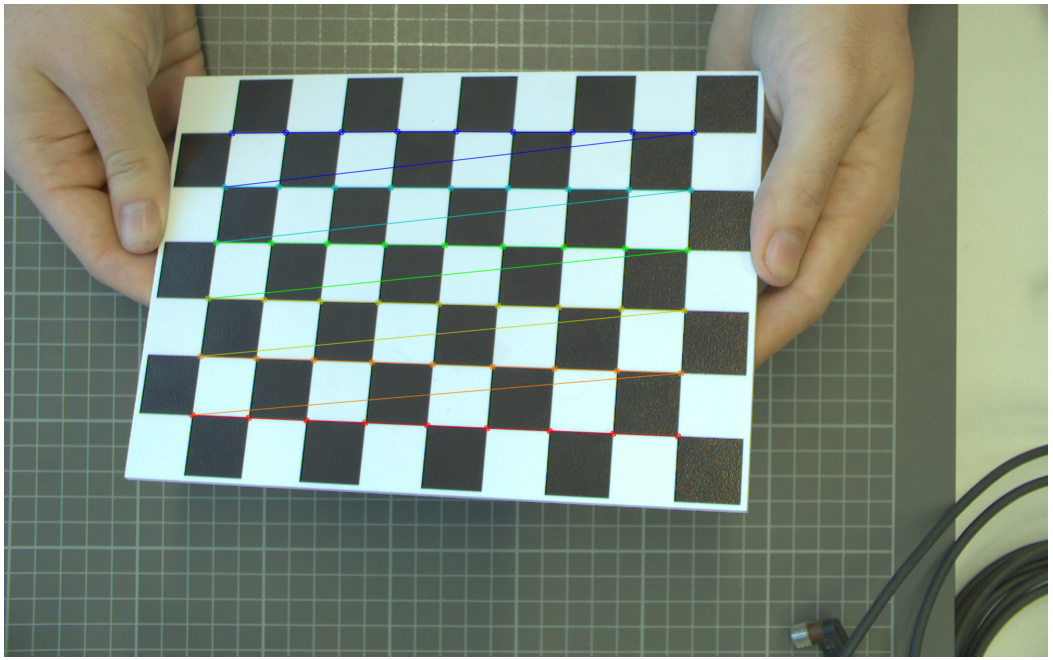

## Segmentace, kontury (04, 05)

Relevatntní funkce:
- `segmentation_two_thresholds`
- `segmentation_auto_threshold`

Hledání kontury:
- `cv2.dilate` [doc](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)
- `cv2.erode`
- `fill_holes`
- `find_contours` -> `(contour_drawn: np.ndarray, count: int, contours: list)`

`enum_contours` (hw01) !

Převod na geometrický útvar:
- `cv2.minAreaRect` -> `(center(x, y), (width, height), angle of rotation)` [guide](https://theailearner.com/tag/cv2-minarearect/)
- `cv2.boundingRect` kolmý na osy x, y
- `cv2.minEnclosingCircle` -> `(center, radius)` (viz hw01)

Interaktivní slider, pokud bude fungovat (elegantnější než tipovat čísla)

## OCR (05)

Obrázek -> preprocessing, transformace -> segmentace na bílo-černou masku -> `improutils.ocr()` přes Tesseract

### Knihovní funkce

In [4]:
def find_holes(img_bin,min_area = 0, max_area=1000000,fill = True):
    """
    Finds inner contours of holes in binary image and filters them using their area. Then it draws binary image from filtered contours. It counts contours as well.

    Parameters
    ----------
    img_bin : ndarray
        Input binary image.
    min_area : int
        Size of contour that is used to filter all smaller contours out.
    max_area : int
        Size of contour that is used to filter all larger contours out.
    Returns
    -------
    contour_drawn : ndarray
        Output binary image with drawn filled filtered contours.
    count : int
        Number of found and filtered contours.
    contours : list
        Found contours.
    """

    contours, hierarchy = cv2.findContours(img_bin,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    # filter out only hole contours (contours that are inside another contour)
    # for more info about hierarchy retrieval modes visit: https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html
    hole_indices = [ i for i in range(len(hierarchy[0])) if hierarchy[0,i,-1] != -1]    
    # filter out contours by area
    contours = [contours[hole_index] for hole_index in hole_indices if min_area < cv2.contourArea(contours[hole_index]) <= max_area]
    # draw contours
    thick = cv2.FILLED
    if not fill: thick = 2
    contours_drawn = cv2.drawContours(np.zeros(img_bin.shape, dtype=np.uint8), contours, -1, color=(255, 255, 255),thickness=thick)
    return contours_drawn, len(contours), contours

### Použití

text = improutils.ocr(result)
print(text)

## Perspektiva - transformace (06)

1) křivý papír (nebo jakákoliv rovina)
2) nalezení referenčních bodů (např. rohy, pokud možno ručně)
3) nalezení homografie (transformační matice)
4) warp

## Perspektiva - měření výšek (06)

Popis referenčních výšek ve zdrojovém obrázku (vždy od povrchu roviny)

### Knihovní funkce

In [5]:
# Funkce pro konverze mezi typy souřadnic
def convert_pt_to_homogenous(pt):
    """
    Convert input point in inhomogeneous coordinates to homogeneous.

    :param pt: ndarray
        Input point in inhomogeneous coordinates.
    :return: ndarray
        Input point in homogeneous coordinates.
    """
    return np.append(pt, np.array(1))

def convert_pt_from_homogenous(pt):
    """
    Convert input point in homogeneous coordinates to inhomogeneous.

    :param pt: ndarray
        Input point in homogeneous coordinates.
    :return: ndarray
        Input point in inhomogeneous coordinates.
    """
    return tuple([elem / pt[-1] for elem in pt[:-1]])

def convert_pts_to_homogenous(pts):
    """
    Convert input points in inhomogeneous coordinates to homogeneous.

    :param pt: ndarray
        Input points in inhomogeneous coordinates.
    :return: ndarray
        Input points in homogeneous coordinates.
    """
    return np.array([convert_pt_to_homogenous(pt) for pt in pts])

def convert_pts_from_homogenous(pts):
    """
    Convert input points in homogeneous coordinates to inhomogeneous.

    :param pt: ndarray
        Input points in homogeneous coordinates.
    :return: ndarray
        Input points in inhomogeneous coordinates.
    """
    return np.array([convert_pt_from_homogenous(pt) for pt in pts])

def _calc_alfa_metric_factor(ref_measurements, vanish_line, vert_vanish_point):
    """ Calculates alfa metric factor using multiple reference measurements via minimization ||As|| = 0. This is done by SVD.
        In depth overview can be found in https://www.robots.ox.ac.uk/~vgg/publications/1999/Criminisi99b/criminisi99b.pdf - PDF page 104.

    :param ref_measurements: list
        Each measurement is in (t_ref, b_ref, height) format. Image coordinates are in inhomogeneous format.
    :param vanish_line: ndarray
        Homogenous coordinates of vanishing line.
    :param vert_vanish_point: ndarray
        Homogenous coordinates of vanishing point in reference direction.
    :return: float
        Scalar value of alfa metric factor calculated by SVD.
    """
    matrix_A = np.empty((len(ref_measurements), 2), dtype='float64')

    for i, (t_ref, b_ref, h_ref) in enumerate(ref_measurements):
        t_ref = convert_pt_to_homogenous(t_ref)
        b_ref = convert_pt_to_homogenous(b_ref)
        beta = np.linalg.norm(np.cross(b_ref, t_ref))
        ro = np.dot(vanish_line, b_ref)
        gamma = np.linalg.norm(np.cross(vert_vanish_point, t_ref))
        matrix_A[i] = (h_ref * ro * gamma, beta)
        # alfa_metric_factor = - np.linalg.norm(np.cross(b_ref, t_ref)) / \
        #                               (h_ref * (np.dot(vanish_line, b_ref)) * np.linalg.norm(np.cross(vert_vanish_point, t_ref)))
        # print(alfa_metric_factor)

    u, s, vh = np.linalg.svd(matrix_A)
    return vh[0, -1] / vh[1, -1]

In [6]:
class HeightEstimator:
    
    def __init__(self, ref_measurements, vl, vz):
        self._vanish_line = vl
        self._vert_vanish_point = vz
        self._alfa_metric_factor = _calc_alfa_metric_factor(ref_measurements, self._vanish_line, self._vert_vanish_point)

    def calc_height(self, top_point, bottom_point):
        """
        Calculates real world height based on top_point and bottom_point measured on image plane.

        :param top_point: ndarray
            Top point in reference direction of the object in inhomogeneous format.
        :param bottom_point: ndarray
            Ground plane point of the object in inhomogeneous format.
        :return: float
            Scalar value representing real world height.
        """
        top_point = convert_pt_to_homogenous(top_point)
        bottom_point = convert_pt_to_homogenous(bottom_point)
        # This formula comes from paper Single view metrology by A. Criminisi.
        height = - np.linalg.norm(np.cross(bottom_point, top_point)) / (
                self._alfa_metric_factor * (np.dot(self._vanish_line, bottom_point)) * np.linalg.norm(np.cross(self._vert_vanish_point, top_point)))
        return height

In [7]:
# Algoritmus automatizovaného výpočtu úběžníků a úběžnic v obraze
"""
References
----------
1.  Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
2.  Bazin, Jean-Charles, and Marc Pollefeys. "3-line RANSAC for orthogonal
    vanishing point detection." 2012 IEEE/RSJ International Conference on
    Intelligent Robots and Systems. IEEE, 2012.
"""
def compute_edgelets(image, sigma=3):
    """Create edgelets as in the paper.

    Uses canny edge detection and then finds (small) lines using probabilstic
    hough transform as edgelets.

    Parameters
    ----------
    image: ndarray
        Image for which edgelets are to be computed.
    sigma: float
        Smoothing to be used for canny edge detection.

    Returns
    -------
    locations: ndarray of shape (n_edgelets, 2)
        Locations of each of the edgelets.
    directions: ndarray of shape (n_edgelets, 2)
        Direction of the edge (tangent) at each of the edgelet.
    strengths: ndarray of shape (n_edgelets,)
        Length of the line segments detected for the edgelet.
    """
    gray_img = color.rgb2gray(image)
    edges = feature.canny(gray_img, sigma)
    lines = transform.probabilistic_hough_line(edges, line_length=3,
                                               line_gap=2)

    locations = []
    directions = []
    strengths = []

    for p0, p1 in lines:
        p0, p1 = np.array(p0), np.array(p1)
        locations.append((p0 + p1) / 2)
        directions.append(p1 - p0)
        strengths.append(np.linalg.norm(p1 - p0))

    # convert to numpy arrays and normalize
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)

    directions = np.array(directions) / \
        np.linalg.norm(directions, axis=1)[:, np.newaxis]

    return (locations, directions, strengths)


def edgelet_lines(edgelets):
    """Compute lines in homogenous system for edglets.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.

    Returns
    -------
    lines: ndarray of shape (n_edgelets, 3)
        Lines at each of edgelet locations in homogenous system.
    """
    locations, directions, _ = edgelets
    normals = np.zeros_like(directions)
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1)
    return lines


def compute_votes(edgelets, model, threshold_inlier=5):
    """Compute votes for each of the edgelet against a given vanishing point.

    Votes for edgelets which lie inside threshold are same as their strengths,
    otherwise zero.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    model: ndarray of shape (3,)
        Vanishing point model in homogenous cordinate system.
    threshold_inlier: float
        Threshold to be used for computing inliers in degrees. Angle between
        edgelet direction and line connecting the  Vanishing point model and
        edgelet location is used to threshold.

    Returns
    -------
    votes: ndarry of shape (n_edgelets,)
        Votes towards vanishing point model for each of the edgelet.

    """
    vp = model[:2] / model[2]

    locations, directions, strengths = edgelets

    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * \
        np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5

    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))

    theta_thresh = threshold_inlier * np.pi / 180
    return (theta < theta_thresh) * strengths


def ransac_vanishing_point(edgelets, num_ransac_iter=2000, threshold_inlier=5):
    """Estimate vanishing point using Ransac.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    num_ransac_iter: int
        Number of iterations to run ransac.
    threshold_inlier: float
        threshold to be used for computing inliers in degrees.

    Returns
    -------
    best_model: ndarry of shape (3,)
        Best model for vanishing point estimated.

    Reference
    ---------
    Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
    """
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 2]

    best_model = None
    best_votes = np.zeros(num_pts)

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]

        current_model = np.cross(l1, l2)

        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # reject degenerate candidates
            continue

        current_votes = compute_votes(
            edgelets, current_model, threshold_inlier)

        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes

    return best_model


def reestimate_model(model, edgelets, threshold_reestimate=5):
    """Reestimate vanishing point using inliers and least squares.

    All the edgelets which are within a threshold are used to reestimate model

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
        All edgelets from which inliers will be computed.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    restimated_model: ndarry of shape (3,)
        Reestimated model for vanishing point in homogenous coordinates.
    """
    locations, directions, strengths = edgelets

    inliers = compute_votes(edgelets, model, threshold_reestimate) > 0
    locations = locations[inliers]
    directions = directions[inliers]
    strengths = strengths[inliers]

    lines = edgelet_lines((locations, directions, strengths))

    a = lines[:, :2]
    b = -lines[:, 2]
    est_model = np.linalg.lstsq(a, b)[0]
    return np.concatenate((est_model, [1.]))


def remove_inliers(model, edgelets, threshold_inlier=10):
    """Remove all inlier edglets of a given model.

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    edgelets_new: tuple of ndarrays
        All Edgelets except those which are inliers to model.
    """
    inliers = compute_votes(edgelets, model, 10) > 0
    locations, directions, strengths = edgelets
    locations = locations[~inliers]
    directions = directions[~inliers]
    strengths = strengths[~inliers]
    edgelets = (locations, directions, strengths)
    return edgelets


def compute_homography_and_warp(image, vp1, vp2, clip=True, clip_factor=3):
    """Compute homography from vanishing points and warp the image.

    It is assumed that vp1 and vp2 correspond to horizontal and vertical
    directions, although the order is not assumed.
    Firstly, projective transform is computed to make the vanishing points go
    to infinty so that we have a fronto parellel view. Then,Computes affine
    transfom  to make axes corresponding to vanishing points orthogonal.
    Finally, Image is translated so that the image is not missed. Note that
    this image can be very large. `clip` is provided to deal with this.

    Parameters
    ----------
    image: ndarray
        Image which has to be wrapped.
    vp1: ndarray of shape (3, )
        First vanishing point in homogenous coordinate system.
    vp2: ndarray of shape (3, )
        Second vanishing point in homogenous coordinate system.
    clip: bool, optional
        If True, image is clipped to clip_factor.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    Returns
    -------
    warped_img: ndarray
        Image warped using homography as described above.
    """
    # Find Projective Transform
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # Translate so that whole of the image is covered
    inter_matrix = np.dot(A, H)

    cords = np.dot(inter_matrix, [[0, 0, image.shape[1], image.shape[1]],
                                  [0, image.shape[0], 0, image.shape[0]],
                                  [1, 1, 1, 1]])
    cords = cords[:2] / cords[2]

    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    final_homography = np.dot(T, inter_matrix)

    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img


def vis_edgelets(image, edgelets, show=True):
    """Helper function to visualize edgelets."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    locations, directions, strengths = edgelets
    for i in range(locations.shape[0]):
        xax = [locations[i, 0] - directions[i, 0] * strengths[i] / 2,
               locations[i, 0] + directions[i, 0] * strengths[i] / 2]
        yax = [locations[i, 1] - directions[i, 1] * strengths[i] / 2,
               locations[i, 1] + directions[i, 1] * strengths[i] / 2]

        plt.plot(xax, yax, 'r-')

    if show:
        plt.show()


def vis_model(image, model, show=True):
    """Helper function to visualize computed model."""
    edgelets = compute_edgelets(image)
    locations, directions, strengths = edgelets
    inliers = compute_votes(edgelets, model, 10) > 0

    edgelets = (locations[inliers], directions[inliers], strengths[inliers])
    locations, directions, strengths = edgelets
    vis_edgelets(image, edgelets, False)
    vp = model / model[2]
    plt.plot(vp[0], vp[1], 'bo')
    for i in range(locations.shape[0]):
        xax = [locations[i, 0], vp[0]]
        yax = [locations[i, 1], vp[1]]
        plt.plot(xax, yax, 'b-.')

    if show:
        plt.show()


def compute_vanishing_points(image, clip_factor=6, reestimate=False):
    """Rectified image with vanishing point computed using ransac.

    Parameters
    ----------
    image: ndarray
        Image which has to be rectified.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    reestimate: bool
        If ransac results are to be reestimated using least squares with
        inlers. Turn this off if getting bad results.
    Returns
    -------
    warped_img: ndarray
        Rectified image.
    """
    #     if type(image) is not np.ndarray:
    #         image = io.imread(image)

    # Compute all edgelets.
    edgelets1 = compute_edgelets(image)
    
    vps = []

    # Find first vanishing point
    vp1 = ransac_vanishing_point(edgelets1, 2000, threshold_inlier=5)
    if reestimate:
        vp1 = reestimate_model(vp1, edgelets1, 5)

    vps.append(vp1)
    
    
    # Remove inlier to remove dominating direction.
    edgelets2 = remove_inliers(vp1, edgelets1, 10)

    # Find second vanishing point
    vp2 = ransac_vanishing_point(edgelets2, 2000, threshold_inlier=5)
    if reestimate:
        vp2 = reestimate_model(vp2, edgelets2, 5)
    vps.append(vp2)

    edgelets3 = remove_inliers(vp2, edgelets2, 10)

    # Find third vanishing point
    vp3 = ransac_vanishing_point(edgelets3, 2000, threshold_inlier=5)
    if reestimate:
        vp3 = reestimate_model(vp3, edgelets3, 5)
    vps.append(vp3)

    # Compute the homography and warp
    #     warped_img = compute_homography_and_warp(image, vp1, vp2, clip_factor=clip_factor)
    
    # Print results
    for i, vp in enumerate(vps):
        print(f'vp{i+1} = [{vp[0]}, {vp[1]}, {vp[2]}]')
        vis_model(image, vp)
    
    return vps

### Použití

## Hloubkové kamery (07)

1. Záznam z Basler ToF
2. Načtení pcd (pointcloud) souboru -- záznamy obsahují zápornou vzdálenost v mm od objektivu
3. Validní zpracování (NaN), kontura objektu
4. změření vzdáleností povrchu objektu (top vs. mean), podložky

In [8]:
def real_measure(w_px, h_px, depth, frame_width, frame_height, fov_horizontal_deg = 57, fov_vertical_deg = 43):
    """
    Function for counting the real measures in meters out of pixel values in depth map images.
    Source: https://stackoverflow.com/a/45481222/1398955
    
    @param w_px : int
        Width in pixels.
    @param h_px : int
        Height in pixels.
    @param depth : float
        Depth value in meters.
    @param frame_width : int
        Frame width in pixels.
    @param frame_height : int
        Frame height in pixels.
    @return w_m : int
        Width in meters.
    @return h_m : int
        Height in meters.
    """
    fov_horizontal = fov_horizontal_deg * np.pi / 180.0
    fov_vertical = fov_vertical_deg * np.pi / 180.0

    horizontal_scaling = 2 * np.tan(fov_horizontal / 2.0) / float(frame_width)
    vertical_scaling = 2 * np.tan(fov_vertical / 2.0) / float(frame_height)

    w_m = w_px * horizontal_scaling * depth
    h_m = h_px * vertical_scaling * depth
    
    return w_m, h_m

def pcd_to_depth(pcd: list[str], height: int, width: int) -> np.ndarray:
    data = pcd
    data = [float(x.split(' ')[2]) for x in data]
    data = np.reshape(data, (height, width))
    return data

## Řádkové kamery (08)

- konstantní rychlost objektu pod kamerou
- ideálně plocha kolmá na kameru... maximalizace odraženého světla
- do té zkoušky to nedají... že ne?

## Detekce QR kódu (08)

- YOLOv8... rozpozná objekt (QR kód)
- pyzbar... dekóduje samotný QR kód na text

`improutils.qr_detect_and_decode`

In [40]:
def detect_qr_code(image):
    res = qr_detect_and_decode(image, return_detections=True)
    # print(res)
    qr_data = res[0][0]
    qr_rect = res[1][0]['bbox_xyxy']
    return qr_data, qr_rect

## Fourierova transformace (09)

1) Převod na frekvenční spektrum  `improutils.apply_fft`
2) vyfiltrování zajímavých frekvencí (např. odstranění nepravidelností)
3) Převod zpět `improutils.inverse_fft`

Vlastnosti spektra:
- stejné rozměry jako původní obrázek (ideálně čtverec)
- bod uprostřed... stejnosměrná složka (posunutí spektra, standardně bod `[0, 0]`)
- symetrické podle os x, y
- komplexní hodnoty z FFT -> amplitudové spektrum (absolutní hodnota), fázové spektrum (argument)

Zdůvodnění symetrie, posunu spektra:
- bez posunutí... amplitudy postupně pro $0, 1, \ldots, n - 1$ period (na jedné z os)
- $n - 1$ period je však (v diskrétním světě) totéž, jako 1 perioda v opačném směru
- tedy rozdíl pouze ve fázi, stejná amplituda (kterou vizualizujeme)
- symetrie se tedy začíná objevovat od $\lceil n / 2 \rceil$ period, kde dojde k přechodu z pravého kraje na levý

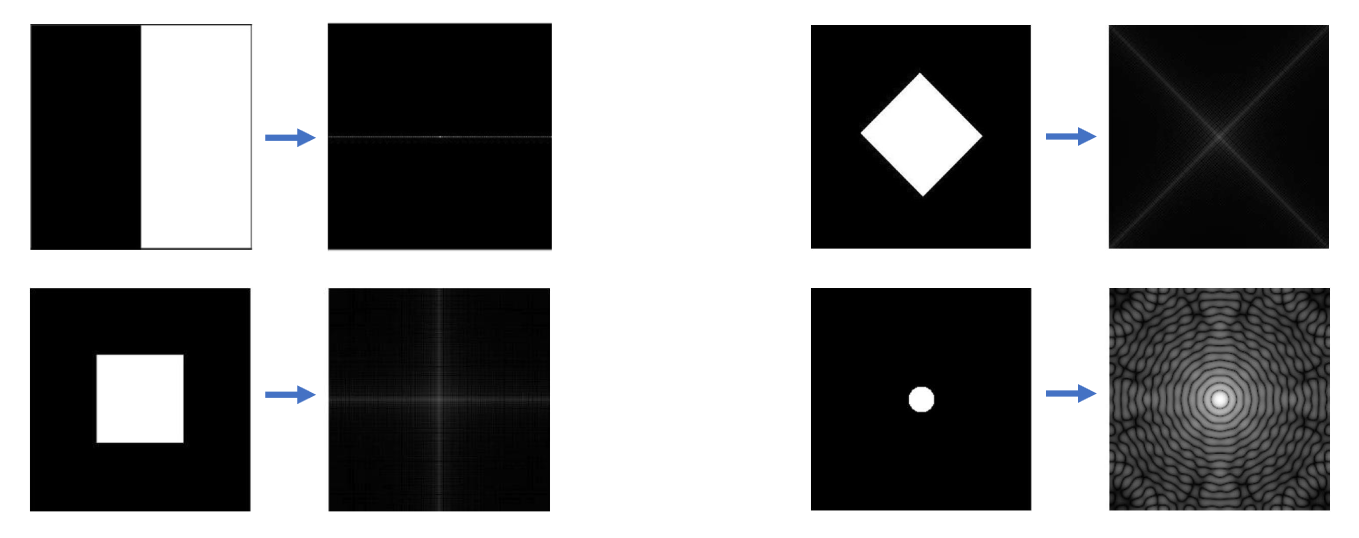

## Polární souřadnice (10)

1) Načtení obrázku z 360° kamery
2) `improutils.warp_to_cartesian`
3) post-process operace -- `improutils.rotate`, `.transpose(1, 0, 2)`
    - `improutils.crop`, asi jen pokud je explicitně povoleno
    - `improutils.resize` roztažení po jedné ose
    - klasické techniky segmentace
4) Použití obrázku -- `improutils.ocr`, detekce čar pomocí Hougha, ...

## Detekce přímek (10)

1) předzpracování obrázku
    - segmentace (někdy lepší než původní obrázek, někdy ne)
    - ořez na relevantní část
2) Filtrování hran -- Cannyho detektor [doc](https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html)
3) Aproximace hran pomocí přímek -- Houghova transformace [doc](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)

In [15]:
def draw_lines(img, lines):
    img_lines = to_3_channels(img)

    for line in lines:
        l = line[0]        
        cv.line(img_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 2, cv.LINE_AA)
    
    return img_lines

## Termokamery (11)

1) Pořízení snímku... TauPlayer (uložit parametry!!!)
2) Načtení 14-bit dat... `cv2.imread("source.png", cv2.IMREAD_ANYDEPTH)`
3) Zobrazení -- normalizace + `plot_images`, nebo `plt.imshow`
4) Převod na ˚C -- `tlin_to_temp`, `-= 273.15`

Odvození propustnosti filtru:
1) `RadiometricModel` s parametry z TauPlayeru
2) Naměřené teploty s/bez filtru -> `temp_to_flux` -> `obj_flux_to_scene_flux`
3) Transmisivita (propustnost) filtru jako podíl `flux_filter.max() / flux_nofilter.max()`
4) Nový `RadiometricModel` s nastavenou propustností `win_trans=filter_trans`

### Knihovna

In [2]:
def flux_to_temp(val):
    return (
        sensor_params.B / np.log(sensor_params.R / 
        (val - sensor_params.O) + sensor_params.F)
    )


def temp_to_flux(val):
    return (
        sensor_params.R / 
        (np.exp(sensor_params.B / val) - sensor_params.F) + sensor_params.O
    )


def tlin_to_temp(val):
    return val * 0.04


def atmospheric_transmissivity(atm_temp_C, humidity, distance_m):
    K1 = 1.5587e+0
    K2 = 6.9390e-2
    K3 = -2.7816e-4
    K4 = 6.8455e-7

    # alpha = 0.01262
    alpha = 0
    beta = -0.00667

    # NOTE: Tayloruv polynom 3. radu
    exponent = (
        K1 + K2 * atm_temp_C + 
        K3 * atm_temp_C**2 + K4 * atm_temp_C**3
    )

    sqrt_H2O = np.sqrt(humidity * np.exp(exponent))
    sqrt_distance_m = np.sqrt(distance_m)
    return np.exp(sqrt_distance_m * (alpha + beta * sqrt_H2O))

In [14]:
class SensorParameters:
    R = 395653
    B = 1428
    F = 1
    O = 156

sensor_params = SensorParameters()

class RadiometricModel:
    obj_trans = 0  # zanedbáváme
    atm_reflex = 0  # zanedbáváme
    win_emis = 0  # zanedbáváme

    def __init__(self, *, obj_emis=0.95, bkg_temp=293.15,
            atm_temp=293.15, atm_trans=0.95, 
            win_temp=293.15, win_trans=0.95):
        # object
        self.obj_emis = obj_emis
        self.obj_reflex = 1 - obj_emis

        # background
        self.bkg_temp = bkg_temp

        # atmosphere
        self.atm_temp = atm_temp  
        self.atm_trans = atm_trans
        self.atm_emis = 1 - atm_trans

        # window
        self.win_temp = win_temp
        self.win_trans = win_trans
        self.win_reflex = 1 - win_trans

In [15]:
def obj_flux_to_scene_flux(model: RadiometricModel, obj_flux):
    bkg_flux = temp_to_flux(model.bkg_temp)
    a_flux = model.obj_reflex * bkg_flux + model.obj_emis * obj_flux
    
    atm_flux = temp_to_flux(model.atm_temp)
    b_flux = model.atm_emis * atm_flux + model.atm_trans * a_flux
    
    win_flux = temp_to_flux(model.win_temp)
    c_flux = model.win_reflex * win_flux + model.win_trans * b_flux
    return c_flux

def scene_flux_to_obj_flux(model: RadiometricModel, scene_flux):
    bkg_flux = temp_to_flux(model.bkg_temp)
    atm_flux = temp_to_flux(model.atm_temp)
    win_flux = temp_to_flux(model.win_temp)
    
    # c_flux == scene_flux
    b_flux = (scene_flux - model.win_reflex * win_flux) / model.win_trans
    
    a_flux = (b_flux - model.atm_emis * atm_flux) / model.atm_trans
    
    obj_flux = (a_flux - model.obj_reflex * bkg_flux) / model.obj_emis
    
    return obj_flux

### Použití

## Objektové charakteristiky, klasifikace (12)

- Formfactor (špičatost)
- Roundness (kulatost)
- Aspect Ratio (poměr stran)
- Convexity (konvexita, vypouklost)
- Solidity (plnost, celistvost)
- Compactness (kompaktnost, hutnost)
- Extent (dosah, rozměrnost)

## Detekce obličejů (12)

- Načtení modelu z `xml` souboru (který si ale na zkoušku nemůžeme sami přinést)

# Kód z úkolů

## Vzdálenosti objektů (hw01)

- `cv2.minAreaRect` -> `(center(x, y), (width, height), angle of rotation)` [guide](https://theailearner.com/tag/cv2-minarearect/)
- `cv2.minEnclosingCircle` -> `(center, radius)`
- následující custom funkce pro vzdálenosti

`enum_contours` !

### Knihovní funkce

In [21]:
def line_segment_to_point_dist(l_pt1: tuple, l_pt2: tuple, dst_pt: tuple):
    # výpočet vzdálenosti mezi úsečkou a bodem
    
    # https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    # https://courses.fit.cvut.cz/BI-LA2/@master/textbook/sec-vzdalenost-od-podprostoru.html
    l_pt1 = np.array(l_pt1)
    l_pt2 = np.array(l_pt2)
    dst_pt = np.array(dst_pt)

    line_vec = l_pt2 - l_pt1
    coef = np.dot(line_vec, dst_pt - l_pt1) / np.linalg.norm(line_vec) ** 2

    if coef < 0:
        projection = l_pt1
        # print("case 1")
    elif coef > 1:
        projection = l_pt2
        # print("case 2")
    else:
        projection = l_pt1 + (coef * line_vec)
        # print("case 3")

    return np.linalg.norm(dst_pt - projection)

In [ ]:
def line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    # výpočet vzdálenosti mezi úsečkami
    
    # min of distance from the two edges of l2
    return min( line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt1),
                line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt2),
                line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt1),
                line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt2))

In [ ]:
def rect_dist(r1_pts, r2_pts):
    # výpočet vzdálenosti mezi dvěma obdélníky
    
    r1_lines = [(r1_pts[0], r1_pts[1]), (r1_pts[1], r1_pts[2]), (r1_pts[2], r1_pts[3]), (r1_pts[3], r1_pts[0])]
    r2_lines = [(r2_pts[0], r2_pts[1]), (r2_pts[1], r2_pts[2]), (r2_pts[2], r2_pts[3]), (r2_pts[3], r2_pts[0])]

    dist = np.inf
    for l1 in r1_lines:
        for l2 in r2_lines:
            dist = min(dist, line_segments_dist(*l1, *l2))

    return dist

In [22]:
def rect_point_dist(r1_pts, r2_pt):
    # výpočet vzdálenosti bodu od obdélníku
    
    r1_lines = [(r1_pts[0], r1_pts[1]), (r1_pts[1], r1_pts[2]), (r1_pts[2], r1_pts[3]), (r1_pts[3], r1_pts[0])]

    dist = np.inf
    for l1 in r1_lines:
        dist = min(dist, line_segment_to_point_dist(*l1, r2_pt))

    return dist

In [28]:
def enum_contours(img: np.ndarray, contours: list) -> None:
    """Take contours (as given from improutils.find_contours), calculate minAreaRect
    and write the index label on the center of the image. Plot this labeled image.
    """
    img_labels = img.copy()

    for idx, cont in enumerate(contours):
        rect = cv2.minAreaRect(np.array(cont))

        # center of the object
        coords = np.array(rect[0], dtype=int)
        print(f"draw {idx} -> {coords}")
    
        cv2.putText(img_labels, str(idx), coords, 0, 8., (255, 0, 0), 10)
    
    plot_images(img_labels)

### Použití

## Hloubkový senzor (hw03)

Pouze pomocné funkce pro hloubkové kamery z úkolu, samotný postup na zkoušku nejspíš není relevantní

In [2]:
# pomocné funkce z vedlejšího notebooku se nechtěly kamarádit (neměly k dispozici cv2 modul, nechápu proč)

def tuple_elems_to_int(t):
    '''Converts all values of input tuple to ints.'''
    assert len(t) == 2, 'Only tuple with two elements is supported!'
    return (int(t[0]), int(t[1]))

def kq_of_line_segment(l_p1, l_p2):
    '''Computes slope (k) and translation (q) of input line segment defined with two points.'''
    a = np.array([[l_p1[0], 1], [l_p2[0], 1]])
    b = np.array([l_p1[1], l_p2[1]])
    
    k, q = np.linalg.solve(a, b)
    
    return k, q

def normal_kq_in_point(p1, k, q):
    '''Computes slope (kn) and translation (qn) of normal (perpendicular) line in point p1.'''
    kn = -1/k
    qn = p1[1] - kn * p1[0]
    return kn, qn

def normal_line_start_end_points(point, k, q, dx):
    '''Computes pixel points of perpendicular line segment of lenght dx in point point 
    to line defined by k and q.'''
    kn, qn = normal_kq_in_point(point, k, q)
    
    x = [point[0]-dx, point[0]+dx]
    y = [kn * x[0] + qn, kn * x[1] + qn]
    
    return (x[0], y[0]), (x[1], y[1])

def draw_norm_line_segment_in_point(l_p1, l_p2, point, dx, image):
    '''Draws perpendicular line segments to line defined with two points of lenght dx
    in point point to input image.'''
    k,q = kq_of_line_segment(l_p1, l_p2)
    start, end = normal_line_start_end_points(point, k, q, dx)
    cv2.line(image, tuple_elems_to_int(start), tuple_elems_to_int(end), (255,255,255), 1, cv2.LINE_4)
    return image

def draw_contour(image, contour):
    '''Draws input contour into image with white color.'''
    cv2.drawContours(image, contour, -1, (255,255,255), 1, cv2.LINE_4)
    return image

In [24]:
def measure_distances_using_impro(image, contour, specified_points, measured_joints_pairs):
    '''Měření vzdáleností na základě obrazu a specifikovaných bodů na kontuře. 
    Na vstupu jsou vstupní obrázek, vypočtená kontura, specifikované "středové" body 
    a páry spojených bodů pro měření. Hledáme vzdálenosti úseček, které jsou ohraničené 
    obrysem kontury, prochází středovým bodem a jsou kolmé na předanou dvojici bodů (nějakou ze spojnic skeletonu).
    '''
    # Lengths of line segments to draw
    # ... it's highly sensitive to the size of body part
    dxs = [12, 12, 15, 40]
    
    # obrys kontury v obrázku
    just_contour = np.zeros_like(image)
    just_contour = draw_contour(just_contour, contour)

    # sem se bude kreslit
    conts_with_norm_lines = np.copy(just_contour)
    
    # ???
    dists = []
    for i, point in enumerate(specified_points):
        p1 = measured_joints_pairs[i][0]
        p2 = measured_joints_pairs[i][1]
        
        # nakreslí normálu ke spojnici p1-p2 v bodě point
        norm_lines = np.zeros_like(just_contour)
        norm_lines = draw_norm_line_segment_in_point(p1, p2, point, dxs[i], norm_lines) ###

        # print(p1, p2, point, dxs[i])
        
        # sjednocení kontur a normály pro vykreslení
        conts_with_norm_lines = cv2.bitwise_or(conts_with_norm_lines, norm_lines)

        # průnik normály a kontury (v ideálním případě 2 body)
        im = cv2.bitwise_and(just_contour, norm_lines)
        idx = np.transpose(np.nonzero(im.T))

        # print("IDX", idx, len(idx))
        
        # iterace přes všechny (ideálně 2) sousední průniky
        for j in range(0, len(idx)-1):
            dist = distance_cm(idx[j], idx[j+1], k)
            # print("DIST", dist, k)

            # ochrana před dvojitým průnikem kolize skrz konturu "v jednom bodě"
            if dist > 2 * k:
                dists.append(dist)

                # nakreslí kolečka do obrázku
                cv2.circle(conts_with_norm_lines, tuple(idx[j].T), 3, 80, -1)
                cv2.circle(conts_with_norm_lines, tuple(idx[j+1].T), 3, 80, -1)
                break
    

    assert len(dists) == 4, f'You don\'t have enough points for measure distances ({len(dists)} were present). You probably chose RIGHT arm, hand, etc. Try choosing left ones.'

    # vykreslí obrázek
    plot_images(conts_with_norm_lines)

    return dists[0], dists[1], dists[2], dists[3]